In [1]:
library(OmnipathR)
# library(nichenetr)
library(tidyverse)
library(dplyr)
library(VennDiagram)
library(ggplot2)
library(utils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2      ✔ purrr   0.3.5 
✔ tibble  3.2.1      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: grid

Loading required package: futile.logger



```import_ligrecextra_interactions```

link: to documentation <https://r.omnipathdb.org/reference/import_ligrecextra_interactions.html>

This LR dataset contains ligand-receptor interactions without literature reference. The ligand-receptor interactions supported by literature references are part of the `omnipath` dataset.


Default params(without filtering resources) has 8350 edges. The table includes columns as follows. 

'source' 'target' 'source_genesymbol' 'target_genesymbol' 'is_directed' 'is_stimulation' 'is_inhibition' 'consensus_direction' 'consensus_stimulation' 'consensus_inhibition' 'sources' 'references' 'curation_effort' 'n_references' 'n_resources'

**The consensus score is if resources supporting the classification of an entity into a category based on combined information of many resources.**

<span style="color:red">I do not undertand how it can have sources but no references.</span>

| sources                                                         | ref | cur_effort | n_ref | n_source |
|-----------------------------------------------------------------|-----|------------|-------|----------|
|      Baccin2019;CellCall;PhosphoPoint;Ramilowski2015_Baccin2019 | NA  | 0          | 0     | 3        |
| Baccin2019;CellCall;PhosphoPoint;Ramilowski2015_Baccin2019;Wang | NA  | 0          | 0     | 4        |
|                                                                 |     |            |       |          |

```curated_ligand_receptor_interactions```

expert curated ligand-receptor resources, provided by this function

In [2]:
# https://r.omnipathdb.org/reference/curated_ligand_receptor_interactions.html
# curated=curated_ligand_receptor_interactions()
lr <- import_ligrecextra_interactions()
lr <- lr %>% filter(!duplicated(lr[, c("source_genesymbol", "target_genesymbol")]))
curated <- curated_ligand_receptor_interactions()
curated <- curated %>% filter(!duplicated(curated[, c("source_genesymbol", "target_genesymbol")]))

```import_omnipath_intercell``` Imports the OmniPath intercellular **communication role annotation** database. It provides information on the roles in inter-cellular signaling. E.g. if a protein is a ligand, a receptor, an extracellular matrix (ECM) component, etc.

In [3]:
anno_raw <- import_omnipath_intercell()
#subset annotation DB to only ligand and receptors
anno_lig <- anno_raw %>%
    dplyr::filter(category %in% c("receptor","ligand"))
# Drop rows where the values in the "parent", "database", and "uniprot" columns are duplicated
anno_raw <- anno_raw %>% filter(!duplicated(anno_raw[, c("parent", "database", "uniprot")]))

In [4]:
?import_omnipath_intercell

# Breaking down complexes

Below, we produce all the the possible pairs. 

Example: lets assume complex G1_G2_G3 is linked to another complex G4_G5_G6

| c1 | c2 | complex_origin    |
|----|----|-------------------|
| G1 | G2 | G1_G2_G3_G4_G5_G6 |
| G1 | G3 | G1_G2_G3_G4_G5_G6 |
| G1 | G4 | G1_G2_G3_G4_G5_G6 |
| G1 | G5 | G1_G2_G3_G4_G5_G6 |
| G1 | G6 | G1_G2_G3_G4_G5_G6 |
| G2 | G1 | G1_G2_G3_G4_G5_G6 |
| G2 | G3 | G1_G2_G3_G4_G5_G6 |
| .. | .. | G1_G2_G3_G4_G5_G6 |

In [5]:
# This function breaks down complex interactions and returns a list of components
# Input: OmniPath_DB
# Output: list of components of complex molecules

break_down_complex <- function(OmniPath_DB) {
    # filter only those are in complex
    complex <- filter(OmniPath_DB, grepl("COMPLEX", target) | grepl("COMPLEX", source))
    complex$source <- sub("COMPLEX:", "", complex$source)
    complex$target <- sub("COMPLEX:", "", complex$target)

    # complexes are seperated into individual components
    components_target <- unique(unlist(strsplit(complex$source_genesymbol, "_")))
    components_source <- unique(unlist(strsplit(complex$target_genesymbol, "_")))
    components_both <- c(components_target, components_source)
    components_both <- unique(components_both)
    return(list(components = components_both, complex = complex))
}

In [6]:
lr$pair <- paste(lr$source_genesymbol, lr$target_genesymbol,sep="_")

In [7]:
curated$pair <- paste(curated$source_genesymbol, curated$target_genesymbol,sep="_")

In [8]:
filter(curated, grepl("COMPLEX", target) | grepl("COMPLEX", source))

source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,pair
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>
Q16552,COMPLEX:Q8NAC3_Q96F46,IL17A,IL17RA_IL17RC,1,1,0,1,1,0,CellChatDB;CellPhoneDB;Cellinker;ICELLNET;SIGNOR,Cellinker:19838198;Cellinker:25204502;Cellinker:9367539;ICELLNET:24011563;SIGNOR:32024054,5,5,5,IL17A_IL17RA_IL17RC
COMPLEX:P05107_P20701,P05362,ITGAL_ITGB2,ICAM1,1,1,0,0,0,0,Baccin2019;CellPhoneDB;ICELLNET;SIGNOR,Baccin2019:16988024;ICELLNET:10940895;ICELLNET:23418628;SIGNOR:12808052,4,4,4,ITGAL_ITGB2_ICAM1
P05000,COMPLEX:P17181_P48551,IFNW1,IFNAR1_IFNAR2,1,1,0,1,1,0,CellChatDB;CellPhoneDB_Cellinker;Cellinker;DLRP_Cellinker;HPMR_Cellinker;ICELLNET;SIGNOR,Cellinker:11278538;Cellinker:1834641;ICELLNET:15032600;SIGNOR:11278538,4,3,4,IFNW1_IFNAR1_IFNAR2
O75326,COMPLEX:P05556_P56199,SEMA7A,ITGA1_ITGB1,1,1,0,1,1,0,CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;Cellinker;ICELLNET;SIGNOR,CellChatDB:22325954;CellPhoneDB:22325954;Cellinker:12879062;Cellinker:22325954;Cellinker:30568033;ICELLNET:17671519;SIGNOR:17377534,7,5,5,SEMA7A_ITGA1_ITGB1
P02458,COMPLEX:O75578_P05556,COL2A1,ITGA10_ITGB1,1,1,0,1,1,0,CellChatDB;CellPhoneDB;Cellinker;HPMR_Cellinker;ICELLNET;SIGNOR,Cellinker:9685391;ICELLNET:15147720;ICELLNET:16988024;ICELLNET:21421911;ICELLNET:26857815;SIGNOR:25169886;SIGNOR:9685391,7,6,5,COL2A1_ITGA10_ITGB1
P10451,COMPLEX:P05556_Q13797,SPP1,ITGA9_ITGB1,1,1,0,1,1,0,Baccin2019;CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;Cellinker;ICELLNET;SIGNOR,Baccin2019:16988024;CellChatDB:21907263;CellPhoneDB:1830891;CellPhoneDB:8970045;Cellinker:10593924;Cellinker:19417209;Cellinker:21907263;ICELLNET:8910476;SIGNOR:24241034,9,8,6,SPP1_ITGA9_ITGB1
P10451,COMPLEX:P05106_P06756,SPP1,ITGAV_ITGB3,1,1,0,1,1,0,Baccin2019;CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;Cellinker;ICELLNET;SIGNOR,Baccin2019:16988024;CellChatDB:21907263;CellPhoneDB:24442579;Cellinker:17868879;Cellinker:21907263;ICELLNET:7532190;SIGNOR:10835423,7,6,6,SPP1_ITGAV_ITGB3
P19320,COMPLEX:P05556_P13612,VCAM1,ITGA4_ITGB1,1,1,0,1,1,0,Baccin2019;CellPhoneDB;ICELLNET;SIGNOR,Baccin2019:16988024;ICELLNET:15263094;SIGNOR:12123670,3,3,4,VCAM1_ITGA4_ITGB1
P01562,COMPLEX:P17181_P48551,IFNA1,IFNAR1_IFNAR2,1,1,0,1,1,0,CellChatDB;Cellinker;DLRP_Cellinker;HPMR_Cellinker;ICELLNET;SIGNOR,Cellinker:11698684;Cellinker:7932753;ICELLNET:15032600;SIGNOR:11278538,4,4,4,IFNA1_IFNAR1_IFNAR2


In [9]:
filter(lr, pair %in% curated$pair)

source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,pair
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>
P0DP23,Q13507,CALM1,TRPC3,1,0,1,1,0,1,CellTalkDB;Fantom5_LRdb;HPRD;HPRD_LRdb;LRdb;TRIP;iTALK,CellTalkDB:11248050;HPRD:15104175;TRIP:11248050;TRIP:11290752;TRIP:12601176;TRIP:18215135,6,5,5,CALM1_TRPC3
P60903,Q9H1D0,S100A10,TRPV6,1,1,0,1,1,0,CellTalkDB;HPRD;TRIP,CellTalkDB:18187190;HPRD:12660155;TRIP:12660155;TRIP:16189514;TRIP:18187190,5,3,3,S100A10_TRPV6
Q9Y219,P46531,JAG2,NOTCH1,1,1,1,1,1,0,Baccin2019;CellCall;CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;CellTalkDB;Cellinker;DLRP_Cellinker;DLRP_talklr;EMBRACE;Fantom5_LRdb;HPMR_Cellinker;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;ICELLNET;KEGG-MEDICUS;Kirouac2010;LRdb;NetPath;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;STRING_talklr;SignaLink3;UniProt_LRdb;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:1100613311006130;CellChatDB:22353464;CellPhoneDB:22353464;CellTalkDB:22353464;Cellinker:11006133;Cellinker:22353464;HPRD:11006133;ICELLNET:16921404;ICELLNET:21352254;ICELLNET:22503540;LRdb:11006133;NetPath:11006133;SIGNOR:9315665;SignaLink3:10958687;SignaLink3:11006133;SignaLink3:18988627;SignaLink3:21071413;SignaLink3:23331499;connectomeDB2020:11006133,19,11,20,JAG2_NOTCH1
O00548,P46531,DLL1,NOTCH1,1,1,0,1,1,0,Baccin2019;CellCall;CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;CellTalkDB;Cellinker;DLRP_Cellinker;DLRP_talklr;EMBRACE;Fantom5_LRdb;HPMR_Cellinker;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;ICELLNET;KEGG-MEDICUS;Kirouac2010;LRdb;NetPath;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;SPIKE;STRING_talklr;UniProt_LRdb;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:1006133;Baccin2019:98194281;CellChatDB:22353464;CellPhoneDB:22353464;CellTalkDB:22353464;Cellinker:11006133;Cellinker:22353464;Cellinker:9819428;HPRD:11006133;ICELLNET:21685328;LRdb:11;LRdb:9819428;NetPath:11006133;SIGNOR:16140393;SPIKE:11006133;SPIKE:17537801;connectomeDB2020:11006133;connectomeDB2020:9819428,18,9,20,DLL1_NOTCH1
P05019,P08069,IGF1,IGF1R,1,1,0,1,1,0,Baccin2019;CA1;CellCall;CellChatDB;CellPhoneDB;CellTalkDB;Cellinker;DIP;DLRP_Cellinker;DLRP_talklr;EMBRACE;Fantom5_LRdb;Guide2Pharma;Guide2Pharma_Cellinker;Guide2Pharma_LRdb;Guide2Pharma_talklr;HPMR;HPMR_Cellinker;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;IntAct;KEGG-MEDICUS;Kirouac2010;LRdb;ProtMapper;REACH_ProtMapper;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;SPIKE;STRING_talklr;SignaLink3;Sparser_ProtMapper;UniProt_LRdb;Wang;connectomeDB2020;iTALK;scConnect;talklr,Baccin2019:1852007;Baccin2019:2877871;CA1:8408032;CellChatDB:14604834;CellTalkDB:2877871;Cellinker:14604834;Cellinker:1852007;Cellinker:2877871;DIP:11287679;DIP:21645859;HPMR:2877871;HPRD:1852007;IntAct:21645859;IntAct:8452530;LRdb:185;LRdb:2877871;ProtMapper:19258508;ProtMapper:23675206;SIGNOR:19029956;SIGNOR:21798082;SPIKE:1852007;SignaLink3:12067807;SignaLink3:1852007;SignaLink3:21071413;SignaLink3:23331499;connectomeDB2020:1852007;connectomeDB2020:2877871,27,15,26,IGF1_IGF1R
P46531,P78504,NOTCH1,JAG1,1,1,0,0,0,0,Baccin2019;BioGRID;CellCall;DIP;HPMR;HPRD;IntAct;Kirouac2010;Lit-BM-17;NetPath;Ramilowski2015_Baccin2019;SPIKE;SignaLink3;Wang,Baccin2019:11006133;BioGRID:11006133;DIP:18660822;HPMR:7697721;HPRD:11006133;IntAct:18660822;IntAct:23086448;Lit-BM-17:11006133;Lit-BM-17:18660822;Lit-BM-17:21820430;NetPath:11006133;SPIKE:11006133;SPIKE:16713569;SPIKE:17537801;SPIKE:18495817;SignaLink3:22390640,16,9,13,NOTCH1_JAG1
P78504,P46531,JAG1,NOTCH1,1,1,1,1,1,0,ACSN;Baccin2019;BioGRID;CellCall;CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;CellTalkDB;Cellinker;DIP;DLRP_Cellinker;DLRP_talklr;EMBRACE;Fantom5_LRdb;HPMR;HPMR_Cellinker;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;ICELLNET;IntAct;KEGG-MEDICUS;Kirouac2010;LRdb;Lit-BM-17;NetPath;Ramilowski2015;Ram

In [10]:
components_lr <- break_down_complex(lr)
components_curated <- break_down_complex(curated)

In [11]:
# This function takes the complex data frame and returns a data frame containing all possible pairwise pairs
# The function loops through each row of the complex data frame and extracts the values from the first and second
# columns. The loop then generates all the possible pairwise pairs using the combn function and appends the results
# to a list. The function then binds the results into a single data frame, switches the values in the source and target
# columns, and binds the rows into a single data frame. The function then drops the self links and returns the data frame.


create_pairwise_pairs <- function(complex){
    # Produce all the possbile pairwise pairs

    results <- list()

    # Loop through each row of the data frame
    for (i in 1:nrow(complex)) {
      # Extract the values from the first column
      values1 <- unlist(strsplit(as.character(complex[i, "source_genesymbol"]), "_"))
      # Extract the values from the second column
      values2 <- unlist(strsplit(as.character(complex[i, "target_genesymbol"]), "_"))
      # Keep the original pair
      original <- paste(complex[i, "source_genesymbol"],complex[i, "target_genesymbol"],sep="_")
      # Generate all the pairwise combinations using combn
      pairs <- combn(c(values1, values2), 2)
      pairs <- t(pairs)
      pairs <- cbind(pairs,original)
      # Append the results to the list
      results[[i]] <- as.data.frame(pairs)
        colnames(results[[i]]) = c("source","target","complex_pair")
        row.names(results[[i]]) <- NULL
    }

    # Bind the results into a single data frame
    result_df2 <- as.data.frame(do.call(rbind, results))

    # Switch the values in the "col1" and "col2" columns
    df1 <- cbind(result_df2[,2], result_df2[,1], result_df2[,3])
    colnames(df1) <- names(result_df2)
    # Bind the rows into a single data frame
    result_df <- rbind(result_df2, df1)


    # Drop the self links
#     result_df <- result_df %>% filter(!duplicated(result_df[, c("source", "target")]))
    
    # create pairs column
    result_df$pair=paste(result_df$source, result_df$target,sep="_")
    
    return(result_df)
}

In [12]:
pairwise_pairs_lr <- create_pairwise_pairs(components_lr$complex)
pairwise_pairs_curated <- create_pairwise_pairs(components_curated$complex)

In [13]:
str(pairwise_pairs_curated)

'data.frame':	4966 obs. of  4 variables:
 $ source      : chr  "IL17A" "IL17A" "IL17RA" "ITGAL" ...
 $ target      : chr  "IL17RA" "IL17RC" "IL17RC" "ITGB2" ...
 $ complex_pair: chr  "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "ITGAL_ITGB2_ICAM1" ...
 $ pair        : chr  "IL17A_IL17RA" "IL17A_IL17RC" "IL17RA_IL17RC" "ITGAL_ITGB2" ...


In [14]:
str(pairwise_pairs_lr)

'data.frame':	8616 obs. of  4 variables:
 $ source      : chr  "IL17A" "IL17A" "IL17RA" "NPNT" ...
 $ target      : chr  "IL17RA" "IL17RC" "IL17RC" "ITGA8" ...
 $ complex_pair: chr  "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "NPNT_ITGA8_ITGB1" ...
 $ pair        : chr  "IL17A_IL17RA" "IL17A_IL17RC" "IL17RA_IL17RC" "NPNT_ITGA8" ...


In [15]:
length(unique(pairwise_pairs_lr$pair))

[1] 3272

In [16]:
filter(pairwise_pairs_curated, complex_pair=="IL17A_IL17RA_IL17RC")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC
IL17RA,IL17RC,IL17A_IL17RA_IL17RC,IL17RA_IL17RC
IL17RA,IL17A,IL17A_IL17RA_IL17RC,IL17RA_IL17A
IL17RC,IL17A,IL17A_IL17RA_IL17RC,IL17RC_IL17A
IL17RC,IL17RA,IL17A_IL17RA_IL17RC,IL17RC_IL17RA


In [17]:
pairwise_pairs_lr %>% filter(!duplicated(pairwise_pairs_lr[, c("complex_pair")]))

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
NPNT,ITGA8,NPNT_ITGA8_ITGB1,NPNT_ITGA8
ITGAL,ITGB2,ITGAL_ITGB2_ICAM1,ITGAL_ITGB2
ICAM1,ITGAL,ICAM1_ITGAL_ITGB2,ICAM1_ITGAL
ITGAD,ITGB2,ITGAD_ITGB2_VCAM1,ITGAD_ITGB2
VCAM1,ITGAD,VCAM1_ITGAD_ITGB2,VCAM1_ITGAD
FGG,ITGA2B,FGG_ITGA2B_ITGB3,FGG_ITGA2B
VTN,ITGA8,VTN_ITGA8_ITGB1,VTN_ITGA8
IFNW1,IFNAR1,IFNW1_IFNAR1_IFNAR2,IFNW1_IFNAR1


In [18]:
pairwise_pairs_curated %>% filter(!duplicated(pairwise_pairs_curated[, c("complex_pair")]))

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
ITGAL,ITGB2,ITGAL_ITGB2_ICAM1,ITGAL_ITGB2
IFNW1,IFNAR1,IFNW1_IFNAR1_IFNAR2,IFNW1_IFNAR1
SEMA7A,ITGA1,SEMA7A_ITGA1_ITGB1,SEMA7A_ITGA1
COL2A1,ITGA10,COL2A1_ITGA10_ITGB1,COL2A1_ITGA10
SPP1,ITGA9,SPP1_ITGA9_ITGB1,SPP1_ITGA9
SPP1,ITGAV,SPP1_ITGAV_ITGB3,SPP1_ITGAV
VCAM1,ITGA4,VCAM1_ITGA4_ITGB1,VCAM1_ITGA4
IFNA1,IFNAR1,IFNA1_IFNAR1_IFNAR2,IFNA1_IFNAR1


# Annotation of components

The complexes are decomposed into their individual components. The Omnipath Intercell annotation database is imported and used to annotate each component. If at least two databases categorize a component as a ligand or receptor, it is annotated as such. If not, we check other possible categories such as extracellular matrix, secreted, and transmembrane 



In [19]:
# This function is to annotate the components from the PPI network with their parent category
# The input of this function is a df with columns of "genesymbol", "score", "parent"
# The output of this function is a df with columns of "genesymbol", "score", "parent"
# This function is used to annotate the components from the PPI network with their parent category

annotate_components <- function(components) {
    #create a df to store annotation
    df <- data.frame(genesymbol = character(length(components)), score = numeric(length(components)),
                     parent = character(length(components)), stringsAsFactors = FALSE)
    
    # Check if the components are categorized as ligands or receptors
    for (x in 1:length(components)) {
    #     maxvalue=max(filter(anno, uniprot==components[x])$consensus_score)
        genename <- components[x]
        parent_score <- sort(table(filter(anno_lig, genesymbol==components[x])$parent), decreasing = T, na.last = T)[1]
        parent_category <- names(parent_score)

        if (is.null(parent_category)) {
          parent_category <- "NA"
          parent_score <- 0
        }

        df[x, "genesymbol"] <- genename
        df[x, "score"] <- parent_score
        df[x, "parent"] <- parent_category

    #     df$genesymbol[x] <- genename
    #     df$score[x] <- parent_score
    #     df$parent[x] <- parent_category
    }
    
    # If a component is not classified as a ligand or receptor, we may consider other categories such as 
    # extracellular matrix, secreted, and transmembrane.# annotated others such as secreted, ecm etc

    df_na <- filter(df, parent=="NA")$genesymbol

    for (x in 1:length(df_na)) {
    #     maxvalue=max(filter(anno, uniprot==components[x])$consensus_score)
        genesymbol <- df_na[x]
        parent_score <- sort(table(filter(anno_raw, genesymbol==df_na[x])$parent), decreasing = T, na.last = T)[1]
        parent_category <- names(parent_score)

        df <- df %>% mutate(parent = ifelse(genesymbol == df_na[x], parent_category, parent))
        df <- df %>% mutate(score = ifelse(genesymbol == df_na[x], parent_score, score))

    }
    
    # replace ecm and secreted with ligand
    df$parent <- replace(df$parent, df$parent == "ecm", "ligand")
    df$parent <- replace(df$parent, df$parent == "secreted", "ligand")
    
    return(df)

}

In [20]:
df_lr = annotate_components(components_lr$components)
df_curated = annotate_components(components_curated$components)

In [21]:
table(df_lr$parent)


       ligand      receptor transmembrane 
          275           198             9 

In [22]:
table(df_curated$parent)


       ligand      receptor transmembrane 
          221           154             3 

# Linking 1

We are using the Omnipath intercellular interaction network, which is the largest available network of its kind, to detect interactions rather than make predictions. The creators of the network have noted that it may contain a large number of false positives. Despite this, we are using it in combination with an annotations database to detect interactions. The network has a size of 98,165 edges.

In [23]:
# Import All post-translational interactions
pt <- import_post_translational_interactions()

In [24]:
get_interaction_resources(dataset = c("omnipath,kinaseextra,pathwayextra,ligrecextra"))

character(0)

In [25]:
# "Separate the annotated components of complexes based on their type."

# This code filters the ligands and receptors from the curated and the lr dataset. It creates
# two dataframes for each dataset, one with ligands and the other with receptors.
# 
# This code is used to prepare the data for the analysis in the next steps. 
# 
# The function names are: filter(), which is used to filter the dataframes.
# The identifiers used are: df_lr, df_curated, parent, ligands_lr, receptors_lr, ligands_curated,
# receptors_curated

ligands_lr <- filter(df_lr, parent=="ligand")
receptors_lr <- filter(df_lr, parent=="receptor")

ligands_curated <- filter(df_curated, parent=="ligand")
receptors_curated <- filter(df_curated, parent=="receptor")


In [26]:
length(c(ligands_lr$genesymbol,receptors_lr$genesymbol))

[1] 473

In [27]:
# Filter the PT network to include only the components of the complexes
# This code filters the PT data to only include rows where the source
# gene is a ligand and the target gene is a receptor. The result is
# saved to the pt object. We are subsetting the big PT network.
# Later this allows us to filter through all the possbile pairwise pairs

pt_lr <- pt %>%
    dplyr::filter(source_genesymbol %in% c(ligands_lr$genesymbol,receptors_lr$genesymbol)) %>%
    dplyr::filter(target_genesymbol %in% c(ligands_lr$genesymbol,receptors_lr$genesymbol)) %>%
    dplyr::distinct()

pt_lr <- pt


# pt_lr <- pt %>%
#     dplyr::filter(source_genesymbol %in% ligands_lr$genesymbol) %>%
#     dplyr::filter(target_genesymbol %in% receptors_lr$genesymbol) %>%
#     dplyr::distinct()

# remove duplicated
pt_lr <- pt_lr %>% filter(!duplicated(pt_lr[, c("source_genesymbol", "target_genesymbol")]))

# create pairs, so its easier to check
pt_lr$pair=paste(pt_lr$source_genesymbol, pt_lr$target_genesymbol,sep="_")



pt_curated <- pt %>%
    dplyr::filter(source_genesymbol %in% c(ligands_curated$genesymbol,receptors_curated$genesymbol)) %>%
    dplyr::filter(target_genesymbol %in% c(ligands_curated$genesymbol,receptors_curated$genesymbol)) %>%
    dplyr::distinct()

pt_curated <- pt

# pt_curated <- pt %>%
#     dplyr::filter(source_genesymbol %in% ligands_curated$genesymbol) %>%
#     dplyr::filter(target_genesymbol %in% receptors_curated$genesymbol) %>%
#     dplyr::distinct()

pt_curated <- pt_curated %>% filter(!duplicated(pt_curated[, c("source_genesymbol", "target_genesymbol")]))
pt_curated$pair=paste(pt_curated$source_genesymbol, pt_curated$target_genesymbol,sep="_")


In [28]:
# The data frame result_df consists of all the pairwise pair combinations, 
# and we are checking if those pairs exist in the PT network
pt_interactions_lr <- pairwise_pairs_lr %>%
    filter(pair %in% pt_lr$pair)

# do the same for the curated

pt_interactions_curated <- pairwise_pairs_curated %>%
    filter(pair %in% pt_curated$pair)

str(pt_interactions_lr)

'data.frame':	3045 obs. of  4 variables:
 $ source      : chr  "IL17A" "IL17A" "NPNT" "NPNT" ...
 $ target      : chr  "IL17RA" "IL17RC" "ITGA8" "ITGB1" ...
 $ complex_pair: chr  "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "NPNT_ITGA8_ITGB1" "NPNT_ITGA8_ITGB1" ...
 $ pair        : chr  "IL17A_IL17RA" "IL17A_IL17RC" "NPNT_ITGA8" "NPNT_ITGB1" ...


In [29]:
str(pt_interactions_curated)

'data.frame':	1879 obs. of  4 variables:
 $ source      : chr  "IL17A" "IL17A" "ITGAL" "ITGB2" ...
 $ target      : chr  "IL17RA" "IL17RC" "ICAM1" "ICAM1" ...
 $ complex_pair: chr  "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "ITGAL_ITGB2_ICAM1" "ITGAL_ITGB2_ICAM1" ...
 $ pair        : chr  "IL17A_IL17RA" "IL17A_IL17RC" "ITGAL_ICAM1" "ITGB2_ICAM1" ...


In [30]:
length(unique(pt_interactions_curated$pair))

[1] 852

In [31]:
length(unique(pt_interactions_lr$pair))

[1] 1262

In [32]:
length(unique(pairwise_pairs_curated$pair))

[1] 2185

In [33]:
length(unique(pairwise_pairs_lr$pair))

[1] 3272

In [34]:
length(unique(filter(pairwise_pairs_lr, !complex_pair %in% pt_interactions_lr$complex_pair)$complex_pair))

[1] 167

In [35]:
length(unique(filter(pairwise_pairs_lr, !complex_pair %in% pt_interactions_lr$complex_pair)$complex_pair))

[1] 167

In [36]:
length(unique(filter(pairwise_pairs_curated, !complex_pair %in% pt_interactions_curated$complex_pair)$complex_pair))

[1] 96

In [37]:
length(unique(pt_interactions_lr$complex_pair))

[1] 1184

In [38]:
length(unique(pt_interactions_curated$complex_pair))

[1] 661

In [39]:
length(unique(pt_interactions_lr$pair))

[1] 1262

In [40]:
length(unique(pt_interactions_curated$pair))

[1] 852

In [41]:
length(unique(pt_interactions_lr$complex_pair))

[1] 1184

In [42]:
filter(pt_interactions_lr, pair %in% pt_interactions_curated$pair)

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC
ITGAL,ICAM1,ITGAL_ITGB2_ICAM1,ITGAL_ICAM1
ITGB2,ICAM1,ITGAL_ITGB2_ICAM1,ITGB2_ICAM1
ICAM1,ITGAL,ICAM1_ITGAL_ITGB2,ICAM1_ITGAL
ICAM1,ITGB2,ICAM1_ITGAL_ITGB2,ICAM1_ITGB2
IFNW1,IFNAR1,IFNW1_IFNAR1_IFNAR2,IFNW1_IFNAR1
IFNW1,IFNAR2,IFNW1_IFNAR1_IFNAR2,IFNW1_IFNAR2
SEMA7A,ITGA1,SEMA7A_ITGA1_ITGB1,SEMA7A_ITGA1


In [43]:
length(unique(pt_interactions_lr$pair))

[1] 1262

In [44]:
filter(pt_interactions_curated, !pair %in% pt_interactions_lr$pair)

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>


In [45]:
head(pt_interactions_lr)

,source,target,complex_pair,pair
,<chr>,<chr>,<chr>,<chr>
1,IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
2,IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC
3,NPNT,ITGA8,NPNT_ITGA8_ITGB1,NPNT_ITGA8
4,NPNT,ITGB1,NPNT_ITGA8_ITGB1,NPNT_ITGB1
5,ITGAL,ICAM1,ITGAL_ITGB2_ICAM1,ITGAL_ICAM1
6,ITGB2,ICAM1,ITGAL_ITGB2_ICAM1,ITGB2_ICAM1


In [46]:
length(setdiff(pairwise_pairs_curated$complex_pair, pt_interactions_curated$complex_pair))

[1] 96

In [47]:
nrow(pt_interactions_lr)

[1] 3045

In [48]:
nrow(pt_interactions_curated)

[1] 1879

**In below we demonstrate that all the possible pairs are produced orginating from the complex pair ```IL17A_IL17RA_IL17RC``` and through PT database, we filter out those does not exist in the DB.**

In [49]:
filter(pairwise_pairs_lr, complex_pair=="IL17A_IL17RA_IL17RC")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC
IL17RA,IL17RC,IL17A_IL17RA_IL17RC,IL17RA_IL17RC
IL17RA,IL17A,IL17A_IL17RA_IL17RC,IL17RA_IL17A
IL17RC,IL17A,IL17A_IL17RA_IL17RC,IL17RC_IL17A
IL17RC,IL17RA,IL17A_IL17RA_IL17RC,IL17RC_IL17RA


In [50]:
filter(pt_interactions_lr, complex_pair=="IL17A_IL17RA_IL17RC")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC
IL17RA,IL17A,IL17A_IL17RA_IL17RC,IL17RA_IL17A


In [51]:
filter(pairwise_pairs_lr, complex_pair=="ITGAL_ITGB2_ICAM1")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
ITGAL,ITGB2,ITGAL_ITGB2_ICAM1,ITGAL_ITGB2
ITGAL,ICAM1,ITGAL_ITGB2_ICAM1,ITGAL_ICAM1
ITGB2,ICAM1,ITGAL_ITGB2_ICAM1,ITGB2_ICAM1
ITGB2,ITGAL,ITGAL_ITGB2_ICAM1,ITGB2_ITGAL
ICAM1,ITGAL,ITGAL_ITGB2_ICAM1,ICAM1_ITGAL
ICAM1,ITGB2,ITGAL_ITGB2_ICAM1,ICAM1_ITGB2


In [52]:
filter(pairwise_pairs_lr, complex_pair=="IGHG1_IGLC1_FCGR3B")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
IGHG1,IGLC1,IGHG1_IGLC1_FCGR3B,IGHG1_IGLC1
IGHG1,FCGR3B,IGHG1_IGLC1_FCGR3B,IGHG1_FCGR3B
IGLC1,FCGR3B,IGHG1_IGLC1_FCGR3B,IGLC1_FCGR3B
IGLC1,IGHG1,IGHG1_IGLC1_FCGR3B,IGLC1_IGHG1
FCGR3B,IGHG1,IGHG1_IGLC1_FCGR3B,FCGR3B_IGHG1
FCGR3B,IGLC1,IGHG1_IGLC1_FCGR3B,FCGR3B_IGLC1


In [53]:
length(unique(pairwise_pairs_lr[!pairwise_pairs_lr$complex_pair %in% pt_interactions_lr$complex_pair,]$complex_pair))

[1] 167

In [54]:
# hist(pairwise_pairs_lr$complex_pair, breaks=3, col="red")

In [55]:
table_data <- as.data.frame(table(pairwise_pairs_lr$complex_pair))

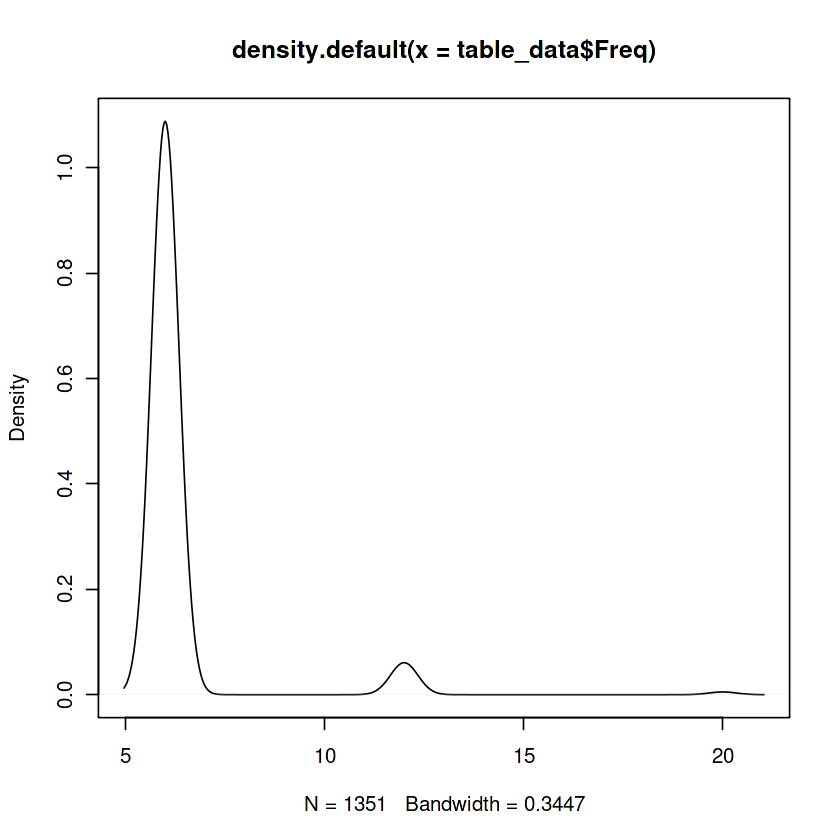

In [56]:
d <- density(table_data$Freq) # returns the density data
plot(d) # plots the results

In [57]:
table_data <- as.data.frame(table(pairwise_pairs_lr$complex_pair))

In [58]:
jpeg(file="Number of binary pairs produced.jpeg")
table_data <- table(pairwise_pairs_lr$complex_pair)
hist(table_data, main = "Number of binary pairs produced from complex", xlab = "# of binary originating from a single complex", ylab = "Count")
dev.off()

png 
  2

In [59]:
table_data <- as.data.frame(table(pt_interactions_lr$complex_pair))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Saving 6.67 x 6.67 in image


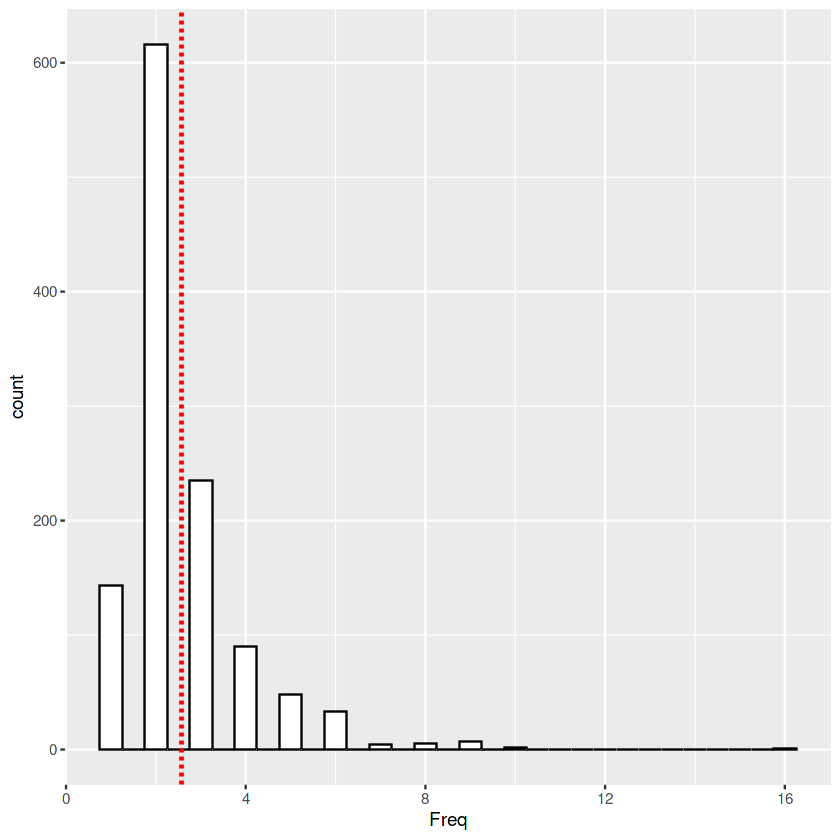

In [60]:
ggplot(table_data, aes(x=Freq)) +
    geom_histogram(binwidth=.5, colour="black", fill="white") +
    geom_vline(aes(xintercept=mean(Freq, na.rm=T)),   # Ignore NA values for mean
               color="red", linetype="dashed", size=1)
ggsave("binaries found.jpeg")

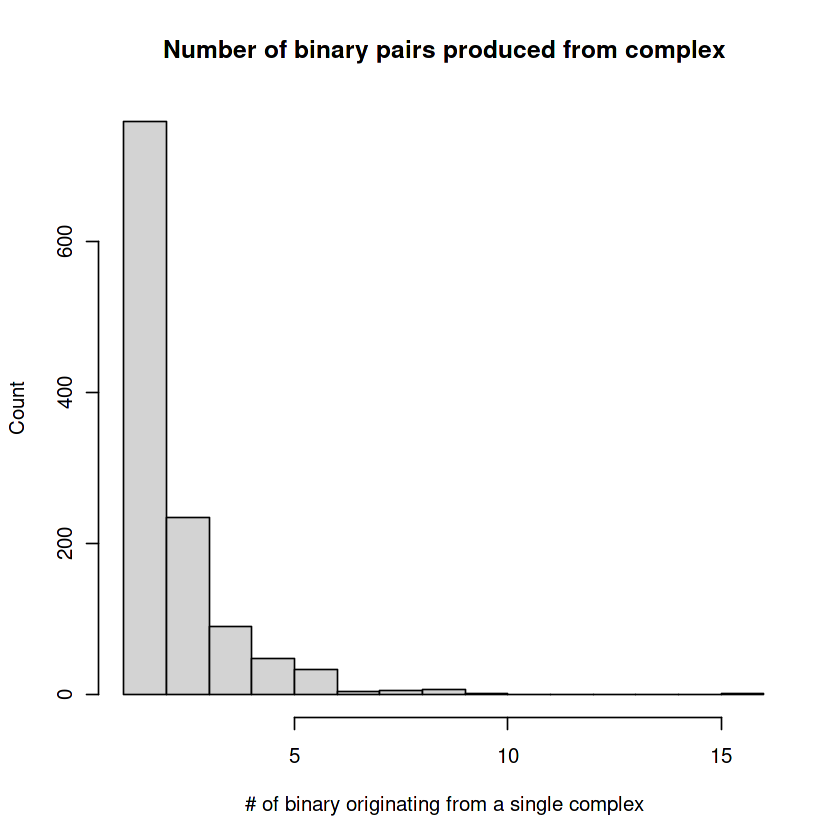

In [61]:
table_data <- table(pt_interactions_lr$complex_pair)
hist(table_data, main = "Number of binary pairs produced from complex", xlab = "# of binary originating from a single complex", ylab = "Count")


# Complexes are broken down, now we can combine with the rest of the db

In [62]:
# This function merges the single components of the complexes that are detected through PT_DB with 
# the single components of the complexes detected through OmniPath
# The function takes as input the OmniPath data frame and the pt_interactions (which the complex are broken down)

merge_single_complex <- function(OmniPath, pt_interactions){
    single_components = filter(OmniPath, !grepl('COMPLEX', target) & !grepl('COMPLEX',source))
    
    single_components <- single_components %>%
      dplyr::select(source_genesymbol, target_genesymbol) %>%
      dplyr::rename(source=source_genesymbol, target=target_genesymbol) %>%
      dplyr::mutate(complex_pair = NA)    
    
    single_components$pair <- paste(single_components$source, single_components$target, sep="_")
    
    #merge the single ones, with complexes componenets that are detected via PT_DB
    complete <- rbind(single_components, pt_interactions)
    
    #remove the duplicated ones, and drop the last ones, which are coming from the complexes
    complete <- complete[ !duplicated(complete[, "pair"], fromLast=F),]
    
    return(complete)
}

In [63]:
lr_binary=filter(lr, !grepl('COMPLEX', target) & !grepl('COMPLEX',source))

In [64]:
curated_binary=filter(curated, !grepl('COMPLEX', target) & !grepl('COMPLEX',source))

In [65]:
merged=rbind(lr_binary,curated_binary)

In [66]:
merged$pair <- paste(merged$source, merged$target, sep="_")

In [67]:
length(unique(merged$pair))

[1] 6984

In [68]:
lr_complex=filter(lr, grepl('COMPLEX', target) | grepl('COMPLEX',source))

In [69]:
curated_complex=filter(curated, grepl('COMPLEX', target) | grepl('COMPLEX',source))

In [70]:
merged=rbind(lr_complex,curated_complex)
merged$pair <- paste(merged$source, merged$target, sep="_")

In [71]:
length(unique(merged$pair))

[1] 1352

In [72]:
complete_lr <- merge_single_complex(lr, pt_interactions_lr)
complete_curated <- merge_single_complex(curated, pt_interactions_curated)

# Protein Descriptions

We use mygene library to get the protein descriptions

In [73]:
library(mygene)

Loading required package: GenomicFeatures

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:tidyr’:

    expand



In [74]:
# map_gene_descriptions function:
# 1. maps gene symbols to gene descriptions using the queryMany function
# 2. maps the protein descriptions to the dataset
# 3. reorders columns and renames columns

map_gene_descriptions <- function(complete) {
    # get gene symbols
    gene_symbols <- unique(c(complete$source,complete$target))
    
    prot_descriptions <- queryMany(gene_symbols, scopes = "symbol", 
                              fields = c("name"), 
                              species = "human", as_dataframe = "True")
    
    prot_descriptions <- as.data.frame(prot_descriptions)
    
    #map protein descriptions to complete set

    for (x in 1:nrow(complete)) {
        ligand_symbol=complete[x,]$source
        receptor_symbol=complete[x,]$target
        ligand_description=filter(prot_descriptions, query==ligand_symbol)$name
        receptor_description=filter(prot_descriptions, query==receptor_symbol)$name
        lig_id=filter(anno_raw, genesymbol==ligand_symbol)$uniprot[1]
        rec_id=filter(anno_raw, genesymbol==receptor_symbol)$uniprot[1]

        if (ligand_symbol=="PIK3CD-AS1") {
          lig_id <- "O00329"
        }

    #     if (is.null(receptor_description)) {
    #       receptor_description <- "NA"
    #     }


        complete[x, "ligand.name"] = ligand_description[1]
        complete[x, "receptor.name"] = receptor_description[1]
        complete[x, "partner_a"] = lig_id
        complete[x, "partner_b"] = rec_id
    }
    
    #reorder columns
    complete <- complete[, c("pair", "source", "ligand.name", "target", "receptor.name", "complex_pair",
                             "partner_a","partner_b")]
    #rename column names
    names(complete) <- c("Pair.Name", "Ligand", "Ligand.Name", "Receptor", "Receptor.Name", "complex_pair",
                        "partner_a","partner_b")
    
    return(complete)
}

In [75]:
complete_lr <- map_gene_descriptions(complete_lr)

Querying chunk 1

Querying chunk 2

Querying chunk 3



Finished
Pass returnall=TRUE to return lists of duplicate or missing query terms.


In [76]:
complete_curated <- map_gene_descriptions(complete_curated)

Querying chunk 1

Querying chunk 2



Finished
Pass returnall=TRUE to return lists of duplicate or missing query terms.


In [77]:
head(complete_curated)

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
EPO_EPOR,EPO,erythropoietin,EPOR,erythropoietin receptor,NA,P01588,P19235
CXCL16_CXCR6,CXCL16,C-X-C motif chemokine ligand 16,CXCR6,C-X-C motif chemokine receptor 6,NA,Q9H2A7,O00574
KITLG_KIT,KITLG,KIT ligand,KIT,"KIT proto-oncogene, receptor tyrosine kinase",NA,P21583,P10721
CXCL9_CXCR3,CXCL9,C-X-C motif chemokine ligand 9,CXCR3,C-X-C motif chemokine receptor 3,NA,Q07325,P49682
CCL5_CCR5,CCL5,C-C motif chemokine ligand 5,CCR5,C-C motif chemokine receptor 5,NA,P13501,P51681
CCL8_CCR5,CCL8,C-C motif chemokine ligand 8,CCR5,C-C motif chemokine receptor 5,NA,P80075,P51681


In [78]:
# filter(previous_db, Receptor=="NOTCH1")

# append the original structure from OmniPath

In [79]:
lr$pair <- paste(lr$source_genesymbol, lr$target_genesymbol, sep="_")
curated$pair <- paste(curated$source_genesymbol, curated$target_genesymbol, sep="_")

Create a column to merge with. We are doing this because the complex pairs in our data have been broken down, while they are not broken down in the original data. The new column will allow us to match and merge the broken-down pairs with the corresponding pairs in the original data

In [80]:
# If the complex pair is not NA, return the complex pair under the to_merge column. 
# else return the ligand and receptor names separated by an underscore
complete_lr <- complete_lr %>% mutate(to_merge = ifelse(!is.na(complex_pair), complex_pair,
                                                  paste(Ligand, Receptor, sep="_")))

complete_curated <- complete_curated %>% mutate(to_merge = ifelse(!is.na(complex_pair), complex_pair,
                                                  paste(Ligand, Receptor, sep="_")))

In [81]:
# Merge the complete_lr data frame with the lr data frame, using the to_merge column 
# in the former and the pair column in the latter
complete_lr <- as.data.frame(merge(complete_lr, lr, by.x = "to_merge", by.y = "pair"))
complete_curated <- as.data.frame(merge(complete_curated, curated, by.x = "to_merge", by.y = "pair"))

In [82]:
# Remove the columns that were used to merge the data
complete_lr <- complete_lr %>% dplyr::select(-to_merge)
complete_lr$annotation_strategy <- "LR"
complete_curated <- complete_curated %>% dplyr::select(-to_merge)
complete_curated$annotation_strategy <- "curated"

# tagging curated ones

In [193]:
complete <- rbind(complete_lr, complete_curated)

In [194]:
complete <- complete %>% 
       mutate(db = replace(annotation_strategy, duplicated(Pair.Name) | 
                              duplicated(Pair.Name, fromLast = TRUE), "both"))

In [195]:
complete <- complete %>% filter(!duplicated(complete[, "Pair.Name"]))

In [196]:
lr_final <- filter(complete, db %in% c("LR","both"))

In [197]:
curated_final <- filter(complete, db %in% c("curated","both"))

In [198]:
curated_final %>% drop_na(complex_pair)

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>
AMHR2_ACVR1,AMHR2,anti-Mullerian hormone receptor type 2,ACVR1,activin A receptor type 1,AMH_ACVR1_AMHR2,Q16671,Q04771,P03971,COMPLEX:Q04771_Q16671,⋯,0,0,0,CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;Cellinker;ICELLNET,CellPhoneDB:22710174;Cellinker:31683698;ICELLNET:32333774,3,3,4,LR,both
AMHR2_AMH,AMHR2,anti-Mullerian hormone receptor type 2,AMH,anti-Mullerian hormone,AMH_AMHR2_BMPR1A,Q16671,P03971,P03971,COMPLEX:P36894_Q16671,⋯,0,0,0,CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;Cellinker;ICELLNET,CellPhoneDB:22710174;Cellinker:12368913;Cellinker:14656478;Cellinker:26003656;Cellinker:7997230;Cellinker:8889695;ICELLNET:32333774,7,7,4,LR,both
BMPR1B_AMHR2,BMPR1B,bone morphogenetic protein receptor type 1B,AMHR2,anti-Mullerian hormone receptor type 2,AMH_AMHR2_BMPR1B,O00238,Q16671,P03971,COMPLEX:O00238_Q16671,⋯,0,0,0,CellPhoneDB;CellPhoneDB_Cellinker;Cellinker,CellPhoneDB:22710174;Cellinker:22710174,2,1,2,LR,both
AMHR2_BMPR1B,AMHR2,anti-Mullerian hormone receptor type 2,BMPR1B,bone morphogenetic protein receptor type 1B,AMH_AMHR2_BMPR1B,Q16671,O00238,P03971,COMPLEX:O00238_Q16671,⋯,0,0,0,CellPhoneDB;CellPhoneDB_Cellinker;Cellinker,CellPhoneDB:22710174;Cellinker:22710174,2,1,2,LR,both
AREG_ERBB2,AREG,amphiregulin,ERBB2,erb-b2 receptor tyrosine kinase 2,AREG_EGFR_ERBB2,P15514,P04626,P15514,COMPLEX:P00533_P04626,⋯,0,0,0,CellChatDB;Cellinker;DLRP_Cellinker;Guide2Pharma_Cellinker;HPMR_Cellinker,Cellinker:10085134;Cellinker:2466334,2,2,2,LR,both
ACVR2A_ACVRL1,ACVR2A,activin A receptor type 2A,ACVRL1,activin A receptor like type 1,BMP10_ACVR2A_ACVRL1,P27037,P37023,O95393,COMPLEX:P27037_P37023,⋯,0,0,0,CellChatDB;Cellinker;HPMR_Cellinker;ICELLNET,CellChatDB:25620979;CellChatDB:26893264;Cellinker:16049014;Cellinker:17068149;Cellinker:26893264;Cellinker:27252362;Cellinker:30246252;ICELLNET:17878607,8,7,3,LR,both
ACVR2B_ACVRL1,ACVR2B,activin A receptor type 2B,ACVRL1,activin A receptor like type 1,BMP10_ACVR2B_ACVRL1,Q13705,P37023,O95393,COMPLEX:P37023_Q13705,⋯,0,0,0,ICELLNET,ICELLNET:17878607,1,1,1,LR,both
BMPR1B_BMPR2,BMPR1B,bone morphogenetic protein receptor type 1B,BMPR2,bone morphogenetic protein receptor type 2,BMP15_BMPR1B_BMPR2,O00238,Q13873,O95972,COMPLEX:O00238_Q13873,⋯,0,0,0,CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;Cellinker;DLRP_Cellinker;HPMR_Cellinker;ICELLNET,CellChatDB:26893264;CellPhoneDB:22710174;Cellinker:12419820;Cellinker:26003656;Cellinker:26893264;Cellinker:27252362;ICELLNET:17878607,7,6,4,LR,both
BMPR2_BMPR1B,BMPR2,bone morphogenetic protein receptor type 2,BMPR1B,bone morphogenetic protein receptor type 1B,BMP15_BMPR1B_BMPR2,Q13873,O00238,O95972,COMPLEX:O00238_Q13873,⋯,0,0,0,CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;Cellinker;DLRP_Cellinker;HPMR_Cellinker;ICELLNET,CellChatDB:26893264;CellPhoneDB:22710174;Cellinker:12419820;Cellinker:26003656;Cellinker:26893264;Cellinker:27252362;ICELLNET:17878607,7,6,4,LR,both


In [199]:
filter(complete, db=="LR")

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>
ABCA1_SHANK1,ABCA1,ATP binding cassette subfamily A member 1,SHANK1,SH3 and multiple ankyrin repeat domains 1,NA,O95477,Q9Y566,O95477,Q9Y566,⋯,0,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:16192279,1,1,2,LR,LR
ACE_AGTR2,ACE,angiotensin I converting enzyme,AGTR2,angiotensin II receptor type 2,NA,P12821,P50052,P12821,P50052,⋯,0,0,0,Baccin2019;CellTalkDB;Fantom5_LRdb;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;iTALK;talklr,Baccin2019:11459796;HPRD:11459796;LRdb:11459796,3,1,7,LR,LR
ACE2_SLC6A19,ACE2,angiotensin converting enzyme 2,SLC6A19,solute carrier family 6 member 19,NA,Q9BYF1,Q695T7,Q9BYF1,Q695T7,⋯,0,0,0,CellTalkDB;IntAct,IntAct:32132184;IntAct:34189428,2,2,2,LR,LR
ACE2_TIGIT,ACE2,angiotensin converting enzyme 2,TIGIT,T cell immunoreceptor with Ig and ITIM domains,NA,Q9BYF1,Q495A1,Q9BYF1,Q495A1,⋯,0,0,0,Cellinker,Cellinker:32589946,1,1,1,LR,LR
ACKR1_CCR5,ACKR1,atypical chemokine receptor 1 (Duffy blood group),CCR5,C-C motif chemokine receptor 5,NA,Q16570,P51681,Q16570,P51681,⋯,0,0,0,Cellinker,Cellinker:29637711,1,1,1,LR,LR
ACKR3_CXCR4,ACKR3,atypical chemokine receptor 3,CXCR4,C-X-C motif chemokine receptor 4,NA,P25106,P61073,P25106,P61073,⋯,0,0,0,Cellinker;IntAct,Cellinker:29637711;IntAct:19380869;IntAct:21730065;IntAct:25775528;IntAct:27331810;IntAct:28862946;IntAct:29386406,7,7,2,LR,LR
ACP4_VSTM2B,ACP4,acid phosphatase 4,VSTM2B,V-set and transmembrane domain containing 2B,NA,Q9BZG2,A6NLU5,Q9BZG2,A6NLU5,⋯,0,0,0,Cellinker,Cellinker:32589946,1,1,1,LR,LR
ACVR2B_DLK1,ACVR2B,activin A receptor type 2B,DLK1,delta like non-canonical Notch ligand 1,NA,Q13705,P80370,Q13705,P80370,⋯,0,0,0,Cellinker,Cellinker:32589946,1,1,1,LR,LR
ACVRL1_CDH5,ACVRL1,activin A receptor like type 1,CDH5,cadherin 5,NA,P37023,P33151,P37023,P33151,⋯,0,0,0,Cellinker,Cellinker:18337748,1,1,1,LR,LR


In [200]:
curated_final %>% drop_na(complex_pair)

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>
AMHR2_ACVR1,AMHR2,anti-Mullerian hormone receptor type 2,ACVR1,activin A receptor type 1,AMH_ACVR1_AMHR2,Q16671,Q04771,P03971,COMPLEX:Q04771_Q16671,⋯,0,0,0,CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;Cellinker;ICELLNET,CellPhoneDB:22710174;Cellinker:31683698;ICELLNET:32333774,3,3,4,LR,both
AMHR2_AMH,AMHR2,anti-Mullerian hormone receptor type 2,AMH,anti-Mullerian hormone,AMH_AMHR2_BMPR1A,Q16671,P03971,P03971,COMPLEX:P36894_Q16671,⋯,0,0,0,CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;Cellinker;ICELLNET,CellPhoneDB:22710174;Cellinker:12368913;Cellinker:14656478;Cellinker:26003656;Cellinker:7997230;Cellinker:8889695;ICELLNET:32333774,7,7,4,LR,both
BMPR1B_AMHR2,BMPR1B,bone morphogenetic protein receptor type 1B,AMHR2,anti-Mullerian hormone receptor type 2,AMH_AMHR2_BMPR1B,O00238,Q16671,P03971,COMPLEX:O00238_Q16671,⋯,0,0,0,CellPhoneDB;CellPhoneDB_Cellinker;Cellinker,CellPhoneDB:22710174;Cellinker:22710174,2,1,2,LR,both
AMHR2_BMPR1B,AMHR2,anti-Mullerian hormone receptor type 2,BMPR1B,bone morphogenetic protein receptor type 1B,AMH_AMHR2_BMPR1B,Q16671,O00238,P03971,COMPLEX:O00238_Q16671,⋯,0,0,0,CellPhoneDB;CellPhoneDB_Cellinker;Cellinker,CellPhoneDB:22710174;Cellinker:22710174,2,1,2,LR,both
AREG_ERBB2,AREG,amphiregulin,ERBB2,erb-b2 receptor tyrosine kinase 2,AREG_EGFR_ERBB2,P15514,P04626,P15514,COMPLEX:P00533_P04626,⋯,0,0,0,CellChatDB;Cellinker;DLRP_Cellinker;Guide2Pharma_Cellinker;HPMR_Cellinker,Cellinker:10085134;Cellinker:2466334,2,2,2,LR,both
ACVR2A_ACVRL1,ACVR2A,activin A receptor type 2A,ACVRL1,activin A receptor like type 1,BMP10_ACVR2A_ACVRL1,P27037,P37023,O95393,COMPLEX:P27037_P37023,⋯,0,0,0,CellChatDB;Cellinker;HPMR_Cellinker;ICELLNET,CellChatDB:25620979;CellChatDB:26893264;Cellinker:16049014;Cellinker:17068149;Cellinker:26893264;Cellinker:27252362;Cellinker:30246252;ICELLNET:17878607,8,7,3,LR,both
ACVR2B_ACVRL1,ACVR2B,activin A receptor type 2B,ACVRL1,activin A receptor like type 1,BMP10_ACVR2B_ACVRL1,Q13705,P37023,O95393,COMPLEX:P37023_Q13705,⋯,0,0,0,ICELLNET,ICELLNET:17878607,1,1,1,LR,both
BMPR1B_BMPR2,BMPR1B,bone morphogenetic protein receptor type 1B,BMPR2,bone morphogenetic protein receptor type 2,BMP15_BMPR1B_BMPR2,O00238,Q13873,O95972,COMPLEX:O00238_Q13873,⋯,0,0,0,CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;Cellinker;DLRP_Cellinker;HPMR_Cellinker;ICELLNET,CellChatDB:26893264;CellPhoneDB:22710174;Cellinker:12419820;Cellinker:26003656;Cellinker:26893264;Cellinker:27252362;ICELLNET:17878607,7,6,4,LR,both
BMPR2_BMPR1B,BMPR2,bone morphogenetic protein receptor type 2,BMPR1B,bone morphogenetic protein receptor type 1B,BMP15_BMPR1B_BMPR2,Q13873,O00238,O95972,COMPLEX:O00238_Q13873,⋯,0,0,0,CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;Cellinker;DLRP_Cellinker;HPMR_Cellinker;ICELLNET,CellChatDB:26893264;CellPhoneDB:22710174;Cellinker:12419820;Cellinker:26003656;Cellinker:26893264;Cellinker:27252362;ICELLNET:17878607,7,6,4,LR,both


In [201]:
#this column is needed when building CellPhoneDB
# concatanated$annotation_strategy <- ifelse(concatanated$curated == TRUE, "OmniPath_curated", "OmniPath")

In [202]:
write.csv(complete, "L_R_reviseD_full_before_fix.csv", row.names=FALSE)

In [203]:
# complete = read.csv('L_R_reviseD_full_before_fix.csv')

In [204]:
filter(complete,Ligand=="PIK3CD-AS1")

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>
PIK3CD-AS1_LY6G6C,PIK3CD-AS1,PIK3CD antisense RNA 1,LY6G6C,lymphocyte antigen 6 family member G6C,NA,O00329,O95867,Q5SR53,O95867,⋯,0,0,0,Fantom5_LRdb;LRdb;iTALK,NA,0,0,2,LR,LR
PIK3CD-AS1_SLC16A4,PIK3CD-AS1,PIK3CD antisense RNA 1,SLC16A4,solute carrier family 16 member 4,NA,O00329,O15374,Q5SR53,O15374,⋯,0,0,0,Fantom5_LRdb;LRdb;iTALK,NA,0,0,2,LR,LR


In [205]:
complete$Ligand <- str_replace(complete$Ligand, "PIK3CD-AS1", "PIK3CD")

In [206]:
complete$Pair.Name <- paste(complete$Ligand, complete$Receptor, sep="_")

In [207]:
complete$dup <- paste(complete$Receptor, complete$Ligand, sep="_")

In [208]:
components <- unique(c(complete$Ligand, complete$Receptor))

In [209]:
length(components)

[1] 2291

In [210]:
annotation <- annotate_components(components)

In [211]:
get_intercell_resources()

[1] "Adhesome"             "Almen2009"            "Baccin2019"          
 [4] "CellCall"             "CellCellInteractions" "CellChatDB"          
 [7] "Cellinker"            "CellPhoneDB"          "CellTalkDB"          
[10] "ComPPI"               "connectomeDB2020"     "CSPA"                
[13] "DGIdb"                "EMBRACE"              "GO_Intercell"        
[16] "GPCRdb"               "Guide2Pharma"         "HGNC"                
[19] "HPA_secretome"        "HPMR"                 "ICELLNET"            
[22] "Integrins"            "iTALK"                "Kirouac2010"         
[25] "LOCATE"               "LRdb"                 "Matrisome"           
[28] "MatrixDB"             "MCAM"                 "Membranome"          
[31] "OmniPath"             "OPM"                  "Phobius"             
[34] "Ramilowski_location"  "Ramilowski2015"       "scConnect"           
[37] "SignaLink_function"   "Surfaceome"           "talklr"              
[40] "TopDB"                "UniProt_keyword"      "UniProt_location"    
[43] "UniProt_topology"     "Zhong2015"

In [212]:
length(unique(anno_raw$genesymbol))

[1] 46207

In [213]:
length(unique(anno_raw$uniprot))

[1] 47281

In [214]:
# ggplot(true_LR, aes(x=score)) +
#     geom_histogram(binwidth=.5, colour="black", fill="white") +
#     geom_vline(aes(xintercept=mean(score, na.rm=T)),   # Ignore NA values for mean
#                color="red", linetype="dashed", size=1)

In [215]:
true_LR <- filter(annotation, parent == "receptor" | parent == "ligand")

In [216]:
annotation[annotation$genesymbol=="BMPR1B",]

,genesymbol,score,parent
,<chr>,<dbl>,<chr>
63,BMPR1B,20,receptor


In [217]:
annotation[annotation$genesymbol=="BMP15",]

,genesymbol,score,parent
,<chr>,<dbl>,<chr>
122,BMP15,18,ligand


In [218]:
true_LR_genespace <- true_LR$genesymbol

In [219]:
adhesive <- filter(annotation, !genesymbol %in% true_LR$genesymbol)

In [220]:
ligands <- filter(true_LR, parent=="ligand")$genesymbol
receptors <- filter(true_LR, parent=="receptor")$genesymbol

In [225]:
# Filter the LR pairs that are not in the correct direction
# Exclude the pairs if the swapped (correct direction) counterparts exist in the database

LR_fix_dir <- complete %>% 
  filter(Ligand %in% receptors & Receptor %in% ligands) #%>% 
  #anti_join(complete, by = c("dup" = "Pair.Name"))
#     filter(!dup %in% complete$Pair.Name)

In [112]:
7415 - nrow(complete)

[1] 0

In [179]:
annotation[annotation$genesymbol=="BMP15",]

,genesymbol,score,parent
,<chr>,<dbl>,<chr>
122,BMP15,18,ligand


In [226]:
complete <- filter(complete, !Pair.Name %in% LR_fix_dir$Pair.Name)

In [115]:
7415 - nrow(complete)

[1] 92

In [227]:
#fix the directions
LR_fix_dir[, c("Ligand", "Receptor", "Ligand.Name", "Receptor.Name",
      "partner_a","partner_b", "source","target","source_genesymbol","target_genesymbol")] <- LR_fix_dir[, c("Receptor", "Ligand", "Receptor.Name", "Ligand.Name",
                                                                                                    "partner_b","partner_a", "target","source","target_genesymbol","source_genesymbol")]

LR_fix_dir["Pair.Name"] <- paste(LR_fix_dir$Ligand, LR_fix_dir$Receptor, sep="_")
LR_fix_dir["dup"] <- paste(LR_fix_dir$Receptor, LR_fix_dir$Ligand, sep="_")

In [228]:
# these are the list of interactions that are strictly in LR direction
true_LR_DB <- complete %>% filter(Ligand %in% ligands & Receptor %in% receptors)

In [229]:
true_LR_DB["True_LR"]=TRUE

In [230]:
LR_fix_dir["True_LR"]=TRUE

In [231]:
true_LR_DB <- rbind(true_LR_DB,LR_fix_dir)

In [232]:
adhesive_DB <- filter(complete, !Pair.Name %in% true_LR_DB$Pair.Name)

In [233]:
adhesive_DB["True_LR"]=FALSE

In [234]:
reversed <- complete[complete$dup %in% complete$Pair.Name,  ]

In [235]:
found_in_LR <- filter(reversed, dup %in% true_LR_DB$Pair.Name)

In [236]:
reversed <- filter(reversed, !Pair.Name %in% found_in_LR$Pair.Name)
reversed <- filter(reversed, !Pair.Name %in% found_in_LR$dup)

In [237]:
adhesive_DB  <- filter(adhesive_DB, !Pair.Name %in% found_in_LR$Pair.Name)
adhesive_DB  <- filter(adhesive_DB, !dup %in% found_in_LR$dup)

In [238]:
# reversed <- adhesive_DB[adhesive_DB$dup %in% adhesive_DB$Pair.Name,  ]

In [239]:
# adhesive_DB <- adhesive_DB[!adhesive_DB$dup %in% true_LR_DB$Pair.Name,  ]

In [240]:
2705 - 2613

[1] 92

In [241]:
# remove the subsetted partition from the original df
adhesive_DB <- adhesive_DB[!adhesive_DB$Pair.Name %in% reversed$Pair.Name,  ]

In [242]:
# true_LR_DB <- filter(true_LR_DB, !Pair.Name %in% reversed_found_in_LR$dup)

In [243]:
# Subset the LR_database data frame to only include rows where we have swapped interactions

subset_lr <- reversed

In [244]:
nrow(subset_lr)

[1] 342

In [245]:
3350 - 2705 # because removed the ones from reversed and also found in LR

[1] 645

In [246]:
nrow(adhesive_DB)

[1] 2613

In [247]:
# Extract all the unique proteins/genes from the subset_lr data frame that have "plexin",
# "neuroligin" or "ADAM" in their Receptor.Name column
# these will be corrected as ligands

plexin_family <- as.vector(subset_lr[grep("plexin", subset_lr$Receptor.Name), ]$Receptor)

neuroligin_family <- as.vector(subset_lr[grep("neuroligin", subset_lr$Receptor.Name), ]$Receptor)

adam_family <- as.vector(subset_lr[grep("ADAM", subset_lr$Receptor.Name), ]$Receptor)

#extract receptors that has annotation of "receptor" under Ligand.Name
receptor_anno <- as.vector(subset_lr[grep("receptor", subset_lr$Ligand.Name), ]$Ligand)

In [248]:
ligand <- c("AGRN", "BMP2", "BMP4", "VTCN1", "CD244", "CD38", "GAS6", "GDNF", "GUCA2A", 
"HHLA2", "IHH", "PSEN1", "NLGN", "NRTN", "RPH3A", "SHH","FLT3LG")

receptor <- c("CD2", "CD27", "CD80", "CD86", "SELL", "CD44", "CD81", "CD8A", "CLEC1B", 
"GLG1", "TYROBP", "FLT3", "ERBB2", "EGFR", "IL1R1", "IL1RAP", "KDR", "NRP1")

In [249]:
# Combine the additional ligands with the plexin, neuroligin, and ADAM families into a vector called ligand
ligand <- unique(c(ligand,plexin_family,neuroligin_family,adam_family))
receptor <- unique(c(receptor,receptor_anno))

In [250]:
# Subset the subset_lr data frame to only include rows where the consensus_direction column is 1
dir <- subset_lr %>% filter(Pair.Name %in% subset_lr$dup & consensus_direction == 1)

In [251]:
# Subset the subset_lr data frame to only include rows where the consensus_direction column is 0
no_dir <- subset_lr %>% filter(Pair.Name %in% subset_lr$dup & consensus_direction == 0)

In [252]:
nrow(no_dir)

[1] 287

In [253]:
nrow(dir)

[1] 55

In [254]:
# Remove rows from no_dir where the pair is already present in dir
in_dir <- dir[dir$dup %in% no_dir$Pair.Name,] 
no_dir <- no_dir[!no_dir$Pair.Name %in% dir$dup,  ] #removal of those in dir below is rm of nodir
# dir <- dir[!dir$Pair.Name %in% in_dir$Pair.Name,] # did not work thats why there is below no fucking idea

In [255]:
x <- dir[!dir$Pair.Name %in% in_dir$Pair.Name,]

In [256]:
dir<-x

In [257]:
nrow(dir)

[1] 6

In [258]:
nrow(in_dir)

[1] 49

In [259]:
238+49+6

[1] 293

In [260]:
342-49

[1] 293

In [261]:
nrow(no_dir)

[1] 238

In [262]:
# remove the interactions where receptor is annotated as ligand
wrong_lig <- no_dir[no_dir$Receptor %in% ligand,]
correct_lig <- no_dir[no_dir$dup %in% wrong_lig$Pair.Name,]
no_dir <- no_dir[!no_dir$Pair.Name %in% c(wrong_lig$Pair.Name, correct_lig$Pair.Name),]

In [263]:
nrow(no_dir)

[1] 212

In [264]:
wrong_rec <- no_dir[no_dir$Ligand %in% receptor,]
wrong_rec <- wrong_rec[!wrong_rec$Pair.Name %in% wrong_rec$dup,]

In [265]:
# remove the interactions where receptor is annotated as ligand
wrong_rec <- no_dir[no_dir$Ligand %in% receptor,]
wrong_rec <- wrong_rec[!wrong_rec$Pair.Name %in% wrong_rec$dup,]
correct_rec <- no_dir[no_dir$dup %in% wrong_rec$Pair.Name,]
no_dir <- no_dir[!no_dir$Pair.Name %in% c(wrong_rec$Pair.Name, correct_rec$Pair.Name),]

In [266]:
49*2

[1] 98

In [267]:
212-98

[1] 114

In [268]:
62*2

[1] 124

In [269]:
nrow(no_dir)

[1] 114

In [270]:
# remove the interactions where receptor is annotated as ligand
# no_dir <- no_dir[!no_dir$Receptor %in% ligand,]

In [271]:
# remove the interactions where ligand is annotated as receptor
# no_dir <- no_dir[!no_dir$Ligand %in% receptor,]

In [272]:
# wrong_lig <- no_dir[no_dir$Receptor %in% ligand,]

In [273]:
# Create an empty data frame called df with the same column names as no_dir
df <- data.frame(matrix(ncol = ncol(no_dir), nrow = 0))
x <- colnames(no_dir)
colnames(df) <- x

In [274]:
# Loop through unique ligands in the no_dir data frame
for (lig in unique(no_dir$Ligand)) {
    vec_clean <- vector()
    # Filter the no_dir data frame to include only rows where Ligand or Receptor column matches the current ligand in the loop
    # this yields the pairs that are swapped.
    r1 <- filter(no_dir, Ligand==lig | Receptor == lig)
#     print(lig)
#     print(nrow(r1))
    vec <- r1$Pair.Name
    
    for (component in vec) {
        comp <- unlist(strsplit(component, split = "_"))
        pair1 <- paste(comp[1], comp[2], sep = "_")
        pair2 <- paste(comp[2], comp[1], sep = "_")
        
        if (!pair1 %in% vec_clean & !pair2 %in% vec_clean) {
            vec_clean <- append(vec_clean, pair1)
        }
    }
    
    # Filter the r1 data frame to include only the unique pairs in vec_clean and append the resulting data frame to df
    c1 <- r1[r1$Pair.Name %in% vec_clean,]
    
    df <- rbind(df,c1)
}

In [275]:
174*2

[1] 348

In [276]:
no_dir_df <- df[!duplicated(df$Pair.Name),]

In [277]:
nrow(no_dir_df)

[1] 57

In [278]:
# Combine the dir and no_dir_df data frames
subset_lr <- rbind(dir,no_dir_df,in_dir,correct_lig,correct_rec)

In [279]:
subset_lr["True_LR"] <- FALSE

In [280]:
# Add the remaining rows of LR_database to subset_lr
adhesive_DB <- rbind(subset_lr,adhesive_DB)

In [281]:
dir_fix <- c("ERBB2_EGFR", "IL1RAP_IL1R1", "NRP1_KDR")

In [282]:
adhesive_DB <- adhesive_DB[!adhesive_DB$Pair.Name %in% dir_fix,  ]

In [283]:
# adhesive_DB <- adhesive_DB[,!names(adhesive_DB) == "dup"]

In [303]:
# found_in_LR["True_LR"]<- TRUE

In [287]:
LR_database <- rbind(true_LR_DB, adhesive_DB,found_in_LR)

In [289]:
LR_database <- LR_database[!LR_database$Pair.Name %in% found_in_LR$dup,]

In [293]:
LR_database <- LR_database[!duplicated(LR_database$Pair.Name),]

In [ ]:
#update the complex_pair columns
all_pairwise <- rbind(pairwise_pairs_curated, pairwise_pairs_lr)
all_pairwise <- all_pairwise[!duplicated(all_pairwise$pair),]
colnames(all_pairwise)[4] <- "Pair.Name"



LR_database <- LR_database %>%
  mutate(complex_pair = coalesce(all_pairwise$complex_pair[match(Pair.Name, all_pairwise$Pair.Name)], complex_pair))

In [304]:
LR_database <- LR_database[,!names(LR_database) == "dup"]

In [413]:
write.csv(LR_database, "LR_21_July.csv", row.names=FALSE)

In [414]:
save(LR_database, file = "LR_21_July.rda")

In [332]:
complex_mols <- filter(LR_database, !complex_pair=="NA")

In [333]:
complex_mols <- complex_mols[duplicated(complex_mols$complex_pair),]

In [335]:
LR_database[LR_database$complex_pair %in% complex_mols$complex_pair,]

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,True_LR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
766,COL11A2_ITGA1,COL11A2,collagen type XI alpha 2 chain,ITGA1,integrin subunit alpha 1,COL11A2_ITGA1_ITGB1,P13942,P56199,P13942,COMPLEX:P05556_P56199,⋯,0,0,CellPhoneDB;ICELLNET,ICELLNET:15147720;ICELLNET:16988024;ICELLNET:21421911;ICELLNET:26857815,4,4,2,LR,both,TRUE
767,COL11A2_ITGB1,COL11A2,collagen type XI alpha 2 chain,ITGB1,integrin subunit beta 1,COL11A2_ITGA1_ITGB1,P13942,P05556,P13942,COMPLEX:P05556_P56199,⋯,0,0,CellPhoneDB;ICELLNET,ICELLNET:15147720;ICELLNET:16988024;ICELLNET:21421911;ICELLNET:26857815,4,4,2,LR,both,TRUE
833,COL2A1_ITGB8,COL2A1,collagen type II alpha 1 chain,ITGB8,integrin subunit beta 8,COL2A1_ITGAV_ITGB8,P02458,P26012,P02458,COMPLEX:P06756_P26012,⋯,0,0,CellChatDB,NA,0,0,1,LR,LR,TRUE
834,COL2A1_ITGAV,COL2A1,collagen type II alpha 1 chain,ITGAV,integrin subunit alpha V,COL2A1_ITGAV_ITGB8,P02458,P06756,P02458,COMPLEX:P06756_P26012,⋯,0,0,CellChatDB,NA,0,0,1,LR,LR,TRUE
874,COL4A2_ITGA2,COL4A2,collagen type IV alpha 2 chain,ITGA2,integrin subunit alpha 2,COL4A2_ITGA2_ITGB1,P08572,P17301,P08572,COMPLEX:P05556_P17301,⋯,1,0,CellChatDB;CellPhoneDB;ICELLNET;SIGNOR,ICELLNET:15147720;ICELLNET:16988024;ICELLNET:21421911;ICELLNET:26857815;SIGNOR:12123670,5,5,4,LR,both,TRUE
875,COL4A2_ITGB1,COL4A2,collagen type IV alpha 2 chain,ITGB1,integrin subunit beta 1,COL4A2_ITGA2_ITGB1,P08572,P05556,P08572,COMPLEX:P05556_P17301,⋯,1,0,CellChatDB;CellPhoneDB;ICELLNET;SIGNOR,ICELLNET:15147720;ICELLNET:16988024;ICELLNET:21421911;ICELLNET:26857815;SIGNOR:12123670,5,5,4,LR,both,TRUE
878,COL4A2_ITGAV,COL4A2,collagen type IV alpha 2 chain,ITGAV,integrin subunit alpha V,COL4A2_ITGAV_ITGB8,P08572,P06756,P08572,COMPLEX:P06756_P26012,⋯,0,0,CellChatDB,NA,0,0,1,LR,LR,TRUE
879,COL4A2_ITGB8,COL4A2,collagen type IV alpha 2 chain,ITGB8,integrin subunit beta 8,COL4A2_ITGAV_ITGB8,P08572,P26012,P08572,COMPLEX:P06756_P26012,⋯,0,0,CellChatDB,NA,0,0,1,LR,LR,TRUE
965,COL5A3_ITGA1,COL5A3,collagen type V alpha 3 chain,ITGA1,integrin subunit alpha 1,COL5A3_ITGA1_ITGB1,P25940,P56199,P25940,COMPLEX:P05556_P56199,⋯,0,0,CellPhoneDB;ICELLNET,ICELLNET:15147720;ICELLNET:16988024;ICELLNET:21421911;ICELLNET:26857815,4,4,2,LR,both,TRUE


In [348]:
annotation[annotation$genesymbol=="IL2",]

,genesymbol,score,parent
,<chr>,<dbl>,<chr>
820,IL2,22,ligand


In [349]:
LR_database[LR_database$Ligand=="IL2",]

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,True_LR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
2164,IL2_CD53,IL2,interleukin 2,CD53,CD53 molecule,NA,P60568,P19397,P60568,P19397,⋯,0,0,CellTalkDB;Cellinker;EMBRACE;Fantom5_LRdb;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;connectomeDB2020;iTALK;talklr,CellTalkDB:7963560;Cellinker:7963560;HPRD:7963560;LRdb:7963560;connectomeDB2020:7963560,5,1,9,LR,both,TRUE
2165,IL2_GYPE,IL2,interleukin 2,GYPE,glycophorin E (MNS blood group),NA,P60568,P15421,P60568,P15421,⋯,0,0,Fantom5_LRdb;LRdb;STRING_talklr;iTALK;talklr,NA,0,0,3,LR,LR,TRUE
2166,IL2_IL2RA,IL2,interleukin 2,IL2RA,interleukin 2 receptor subunit alpha,NA,P60568,P01589,P60568,P01589,⋯,1,0,Baccin2019;CellCall;CellTalkDB;DIP;DLRP_talklr;EMBRACE;Fantom5_LRdb;Guide2Pharma;HPMR;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;InnateDB;IntAct;LRdb;NetPath;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;STRING_talklr;UniProt_LRdb;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:15265897;Baccin2019:1993646;CellTalkDB:15265897;DIP:17032757;HPMR:15265897;HPMR:15933202;HPRD:1993646;InnateDB:12649439;InnateDB:15178252;InnateDB:1940342;InnateDB:3095922;InnateDB:6815536;InnateDB:8580082;InnateDB:8894436;InnateDB:8960125;IntAct:17032757;LRdb:15265897;LRdb:2;NetPath:3116143;NetPath:8260650;SIGNOR:16477002;connectomeDB2020:15265897;connectomeDB2020:1993646,23,16,18,LR,both,TRUE
2167,IL2_IL2RB,IL2,interleukin 2,IL2RB,interleukin 2 receptor subunit beta,NA,P60568,P14784,P60568,P14784,⋯,1,0,Baccin2019;CellCall;CellTalkDB;DIP;DLRP_talklr;Fantom5_LRdb;Guide2Pharma;HPMR;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;InnateDB;IntAct;LRdb;NetPath;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;STRING_talklr;UniProt_LRdb;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:11035066;Baccin2019:15265897;Baccin2019:8049354;CellTalkDB:15265897;DIP:22446627;DIP:8006584;HPMR:15265897;HPMR:15933202;HPRD:11035066;HPRD:8049354;InnateDB:15178252;InnateDB:1940342;InnateDB:3095922;InnateDB:3098894;InnateDB:8568232;IntAct:22446627;LRdb:11035066;LRdb:15265897;LRdb:8049354;NetPath:3116143;NetPath:8260650;SIGNOR:16477002;connectomeDB2020:11035066;connectomeDB2020:15265897;connectomeDB2020:8049354,25,14,17,LR,both,TRUE
2168,IL2_IL2RG,IL2,interleukin 2,IL2RG,interleukin 2 receptor subunit gamma,NA,P60568,P31785,P60568,P31785,⋯,1,0,ACSN_SignaLink3;Baccin2019;CellCall;CellTalkDB;DIP;DLRP_talklr;Fantom5_LRdb;Guide2Pharma;HPMR;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;InnateDB;InnateDB_SignaLink3;LRdb;NetPath;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;SignaLink3;UniProt_LRdb;Wang;connectomeDB2020;iTALK;scConnect;talklr,Baccin2019:10662798;Baccin2019:15265897;Baccin2019:8049354;CellTalkDB:15265897;DIP:8006584;HPMR:15265897;HPMR:15933202;HPRD:10662798;HPRD:8049354;InnateDB:11418623;InnateDB:7681595;InnateDB:8568232;LRdb:10662798;LRdb:15265897;LRdb:8049354;NetPath:8049354;NetPath:8260650;SIGNOR:16477002;SignaLink3:10807786;SignaLink3:10820393;SignaLink3:10849428;SignaLink3:11418623;SignaLink3:12095053;SignaLink3:15289500;SignaLink3:15563472;SignaLink3:16212621;SignaLink3:16799562;SignaLink3:17371980;SignaLink3:1825141;SignaLink3:18758473;SignaLink3:19528259;SignaLink3:19833085;SignaLink3:20856220;SignaLink3:21840487;SignaLink3:22224781;SignaLink3:23124025;SignaLink3:23180781;SignaLink3:23331499;SignaLink3:23650441;SignaLink3:24829413;SignaLink3:26192618;SignaLink3:26755705;SignaLink3:2965306;SignaLink3:6164929;SignaLink3:7512720;SignaLink3:7521688;SignaLink3:7681595;SignaLink3:7829965;SignaLink3:8683106;SignaLink3:9625766;connectomeDB2020:10662798;connectomeDB2020:15265897;connectomeDB2020:8049354,53,40,18,LR,both,TRUE
2169,IL2_NGFR,IL2,interleukin 2,NGFR,nerve growth factor receptor,NA,P60568,P08138,P60568,P08138,⋯,0,

In [385]:
all_pairwise <- rbind(pairwise_pairs_curated, pairwise_pairs_lr)
all_pairwise <- all_pairwise[!duplicated(all_pairwise$pair),]

In [386]:
colnames(all_pairwise)[4] <- "Pair.Name"
# colnames(all_pairwise)[3] <- "complex_pair_all"

In [388]:
LR_database_up <- LR_database %>%
  mutate(complex_pair = coalesce(all_pairwise$complex_pair[match(Pair.Name, all_pairwise$Pair.Name)], complex_pair))

In [389]:
complex_mols <- filter(LR_database_up, !complex_pair=="NA")

In [390]:
complex_mols <- complex_mols[duplicated(complex_mols$complex_pair),]

In [392]:
x=LR_database_up[LR_database_up$complex_pair %in% complex_mols$complex_pair,]

In [399]:
x[x$complex_pair=="IL2_IL2RA_IL2RB_IL2RG",]

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,True_LR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
2166,IL2_IL2RA,IL2,interleukin 2,IL2RA,interleukin 2 receptor subunit alpha,IL2_IL2RA_IL2RB_IL2RG,P60568,P01589,P60568,P01589,⋯,1,0,Baccin2019;CellCall;CellTalkDB;DIP;DLRP_talklr;EMBRACE;Fantom5_LRdb;Guide2Pharma;HPMR;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;InnateDB;IntAct;LRdb;NetPath;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;STRING_talklr;UniProt_LRdb;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:15265897;Baccin2019:1993646;CellTalkDB:15265897;DIP:17032757;HPMR:15265897;HPMR:15933202;HPRD:1993646;InnateDB:12649439;InnateDB:15178252;InnateDB:1940342;InnateDB:3095922;InnateDB:6815536;InnateDB:8580082;InnateDB:8894436;InnateDB:8960125;IntAct:17032757;LRdb:15265897;LRdb:2;NetPath:3116143;NetPath:8260650;SIGNOR:16477002;connectomeDB2020:15265897;connectomeDB2020:1993646,23,16,18,LR,both,TRUE
2167,IL2_IL2RB,IL2,interleukin 2,IL2RB,interleukin 2 receptor subunit beta,IL2_IL2RA_IL2RB_IL2RG,P60568,P14784,P60568,P14784,⋯,1,0,Baccin2019;CellCall;CellTalkDB;DIP;DLRP_talklr;Fantom5_LRdb;Guide2Pharma;HPMR;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;InnateDB;IntAct;LRdb;NetPath;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;STRING_talklr;UniProt_LRdb;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:11035066;Baccin2019:15265897;Baccin2019:8049354;CellTalkDB:15265897;DIP:22446627;DIP:8006584;HPMR:15265897;HPMR:15933202;HPRD:11035066;HPRD:8049354;InnateDB:15178252;InnateDB:1940342;InnateDB:3095922;InnateDB:3098894;InnateDB:8568232;IntAct:22446627;LRdb:11035066;LRdb:15265897;LRdb:8049354;NetPath:3116143;NetPath:8260650;SIGNOR:16477002;connectomeDB2020:11035066;connectomeDB2020:15265897;connectomeDB2020:8049354,25,14,17,LR,both,TRUE
2168,IL2_IL2RG,IL2,interleukin 2,IL2RG,interleukin 2 receptor subunit gamma,IL2_IL2RA_IL2RB_IL2RG,P60568,P31785,P60568,P31785,⋯,1,0,ACSN_SignaLink3;Baccin2019;CellCall;CellTalkDB;DIP;DLRP_talklr;Fantom5_LRdb;Guide2Pharma;HPMR;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;InnateDB;InnateDB_SignaLink3;LRdb;NetPath;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;SignaLink3;UniProt_LRdb;Wang;connectomeDB2020;iTALK;scConnect;talklr,Baccin2019:10662798;Baccin2019:15265897;Baccin2019:8049354;CellTalkDB:15265897;DIP:8006584;HPMR:15265897;HPMR:15933202;HPRD:10662798;HPRD:8049354;InnateDB:11418623;InnateDB:7681595;InnateDB:8568232;LRdb:10662798;LRdb:15265897;LRdb:8049354;NetPath:8049354;NetPath:8260650;SIGNOR:16477002;SignaLink3:10807786;SignaLink3:10820393;SignaLink3:10849428;SignaLink3:11418623;SignaLink3:12095053;SignaLink3:15289500;SignaLink3:15563472;SignaLink3:16212621;SignaLink3:16799562;SignaLink3:17371980;SignaLink3:1825141;SignaLink3:18758473;SignaLink3:19528259;SignaLink3:19833085;SignaLink3:20856220;SignaLink3:21840487;SignaLink3:22224781;SignaLink3:23124025;SignaLink3:23180781;SignaLink3:23331499;SignaLink3:23650441;SignaLink3:24829413;SignaLink3:26192618;SignaLink3:26755705;SignaLink3:2965306;SignaLink3:6164929;SignaLink3:7512720;SignaLink3:7521688;SignaLink3:7681595;SignaLink3:7829965;SignaLink3:8683106;SignaLink3:9625766;connectomeDB2020:10662798;connectomeDB2020:15265897;connectomeDB2020:8049354,53,40,18,LR,both,TRUE
14331,IL2RA_IL2RG,IL2RA,interleukin 2 receptor subunit alpha,IL2RG,interleukin 2 receptor subunit gamma,IL2_IL2RA_IL2RB_IL2RG,P01589,P31785,P60568,COMPLEX:P01589_P14784_P31785,⋯,1,0,Cellinker;DLRP_Cellinker;HPMR_Cellinker;ICELLNET;KEGG-MEDICUS,Cellinker:15265897;ICELLNET:15546386,2,2,3,LR,both,FALSE
14341,IL2RB_IL2RA,IL2RB,interleukin 2 receptor subunit beta,IL2RA,interleukin 2 receptor subunit alpha,IL2_IL2RA_IL2RB_IL2RG,P14784,P01589,P60568,COMPLEX:P01589_P14784_P31785,⋯,1,0,Cellinker;DLRP_Cellinker;HPMR_Cellinker;ICELLNE

In [394]:
LR_database <- LR_database_up

In [403]:
filter(LR_database,complex_pair=="IL2_IL2RA_IL2RB_IL2RG")

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,True_LR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
2166,IL2_IL2RA,IL2,interleukin 2,IL2RA,interleukin 2 receptor subunit alpha,IL2_IL2RA_IL2RB_IL2RG,P60568,P01589,P60568,P01589,⋯,1,0,Baccin2019;CellCall;CellTalkDB;DIP;DLRP_talklr;EMBRACE;Fantom5_LRdb;Guide2Pharma;HPMR;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;InnateDB;IntAct;LRdb;NetPath;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;STRING_talklr;UniProt_LRdb;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:15265897;Baccin2019:1993646;CellTalkDB:15265897;DIP:17032757;HPMR:15265897;HPMR:15933202;HPRD:1993646;InnateDB:12649439;InnateDB:15178252;InnateDB:1940342;InnateDB:3095922;InnateDB:6815536;InnateDB:8580082;InnateDB:8894436;InnateDB:8960125;IntAct:17032757;LRdb:15265897;LRdb:2;NetPath:3116143;NetPath:8260650;SIGNOR:16477002;connectomeDB2020:15265897;connectomeDB2020:1993646,23,16,18,LR,both,TRUE
2167,IL2_IL2RB,IL2,interleukin 2,IL2RB,interleukin 2 receptor subunit beta,IL2_IL2RA_IL2RB_IL2RG,P60568,P14784,P60568,P14784,⋯,1,0,Baccin2019;CellCall;CellTalkDB;DIP;DLRP_talklr;Fantom5_LRdb;Guide2Pharma;HPMR;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;InnateDB;IntAct;LRdb;NetPath;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;STRING_talklr;UniProt_LRdb;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:11035066;Baccin2019:15265897;Baccin2019:8049354;CellTalkDB:15265897;DIP:22446627;DIP:8006584;HPMR:15265897;HPMR:15933202;HPRD:11035066;HPRD:8049354;InnateDB:15178252;InnateDB:1940342;InnateDB:3095922;InnateDB:3098894;InnateDB:8568232;IntAct:22446627;LRdb:11035066;LRdb:15265897;LRdb:8049354;NetPath:3116143;NetPath:8260650;SIGNOR:16477002;connectomeDB2020:11035066;connectomeDB2020:15265897;connectomeDB2020:8049354,25,14,17,LR,both,TRUE
2168,IL2_IL2RG,IL2,interleukin 2,IL2RG,interleukin 2 receptor subunit gamma,IL2_IL2RA_IL2RB_IL2RG,P60568,P31785,P60568,P31785,⋯,1,0,ACSN_SignaLink3;Baccin2019;CellCall;CellTalkDB;DIP;DLRP_talklr;Fantom5_LRdb;Guide2Pharma;HPMR;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;InnateDB;InnateDB_SignaLink3;LRdb;NetPath;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;SignaLink3;UniProt_LRdb;Wang;connectomeDB2020;iTALK;scConnect;talklr,Baccin2019:10662798;Baccin2019:15265897;Baccin2019:8049354;CellTalkDB:15265897;DIP:8006584;HPMR:15265897;HPMR:15933202;HPRD:10662798;HPRD:8049354;InnateDB:11418623;InnateDB:7681595;InnateDB:8568232;LRdb:10662798;LRdb:15265897;LRdb:8049354;NetPath:8049354;NetPath:8260650;SIGNOR:16477002;SignaLink3:10807786;SignaLink3:10820393;SignaLink3:10849428;SignaLink3:11418623;SignaLink3:12095053;SignaLink3:15289500;SignaLink3:15563472;SignaLink3:16212621;SignaLink3:16799562;SignaLink3:17371980;SignaLink3:1825141;SignaLink3:18758473;SignaLink3:19528259;SignaLink3:19833085;SignaLink3:20856220;SignaLink3:21840487;SignaLink3:22224781;SignaLink3:23124025;SignaLink3:23180781;SignaLink3:23331499;SignaLink3:23650441;SignaLink3:24829413;SignaLink3:26192618;SignaLink3:26755705;SignaLink3:2965306;SignaLink3:6164929;SignaLink3:7512720;SignaLink3:7521688;SignaLink3:7681595;SignaLink3:7829965;SignaLink3:8683106;SignaLink3:9625766;connectomeDB2020:10662798;connectomeDB2020:15265897;connectomeDB2020:8049354,53,40,18,LR,both,TRUE
14331,IL2RA_IL2RG,IL2RA,interleukin 2 receptor subunit alpha,IL2RG,interleukin 2 receptor subunit gamma,IL2_IL2RA_IL2RB_IL2RG,P01589,P31785,P60568,COMPLEX:P01589_P14784_P31785,⋯,1,0,Cellinker;DLRP_Cellinker;HPMR_Cellinker;ICELLNET;KEGG-MEDICUS,Cellinker:15265897;ICELLNET:15546386,2,2,3,LR,both,FALSE
14341,IL2RB_IL2RA,IL2RB,interleukin 2 receptor subunit beta,IL2RA,interleukin 2 receptor subunit alpha,IL2_IL2RA_IL2RB_IL2RG,P14784,P01589,P60568,COMPLEX:P01589_P14784_P31785,⋯,1,0,Cellinker;DLRP_Cellinker;HPMR_Cellinker;ICELLNE

In [404]:
filter(LR_database, complex_pair=="COL2A1_ITGAV_ITGB8")

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,True_LR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
833,COL2A1_ITGB8,COL2A1,collagen type II alpha 1 chain,ITGB8,integrin subunit beta 8,COL2A1_ITGAV_ITGB8,P02458,P26012,P02458,COMPLEX:P06756_P26012,⋯,0,0,CellChatDB,NA,0,0,1,LR,LR,TRUE
834,COL2A1_ITGAV,COL2A1,collagen type II alpha 1 chain,ITGAV,integrin subunit alpha V,COL2A1_ITGAV_ITGB8,P02458,P06756,P02458,COMPLEX:P06756_P26012,⋯,0,0,CellChatDB,NA,0,0,1,LR,LR,TRUE


In [405]:
LR_database["dup"] <- paste0(LR_database$Receptor, "_", LR_database$Ligand)

In [183]:
LR_database <- LR_database[!LR_database$Pair.Name %in% found_in_LR$dup,]

In [187]:
LR_database["dup"] <- paste0(LR_database$Receptor, "_", LR_database$Ligand)

In [409]:
LR_database <- LR_database[,!names(LR_database) == "dup"]

In [410]:
write.csv(LR_database, "LR_revised_latest.rda.csv", row.names=FALSE)

In [411]:
save(LR_database, file = "LR_revised_latest.rda")

In [191]:
write.csv(LR_database, "LR_5_July.csv", row.names=FALSE)

In [192]:
save(LR_database, file = "LR_5_July.rda")

In [168]:
LR_database[LR_database$True_LR==TRUE,]

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,True_LR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
1,A2M_LRP1,A2M,alpha-2-macroglobulin,LRP1,LDL receptor related protein 1,NA,P01023,Q07954,P01023,Q07954,⋯,1,0,AlzPathway;Baccin2019;CellTalkDB;EMBRACE;Fantom5_LRdb;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;STRING_talklr;Wang;connectomeDB2020;iTALK;talklr,AlzPathway:19026743;Baccin2019:10652313;Baccin2019:12194978;Baccin2019:1702392;CellTalkDB:10652313;HPRD:10652313;HPRD:12194978;LRdb:10652313;connectomeDB2020:10652313;connectomeDB2020:12194978;connectomeDB2020:1702392,11,4,11,LR,both,TRUE
2,ACTR2_ADRB2,ACTR2,actin related protein 2,ADRB2,adrenoceptor beta 2,NA,P61160,P07550,P61160,P07550,⋯,0,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,TRUE
3,ACTR2_LDLR,ACTR2,actin related protein 2,LDLR,low density lipoprotein receptor,NA,P61160,P01130,P61160,P01130,⋯,0,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,TRUE
4,ACTR2_LRP2,ACTR2,actin related protein 2,LRP2,LDL receptor related protein 2,NA,P61160,P98164,P61160,P98164,⋯,0,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,TRUE
5,ADAM11_CCR4,ADAM11,ADAM metallopeptidase domain 11,CCR4,C-C motif chemokine receptor 4,NA,O75078,P51679,O75078,P51679,⋯,1,0,Kirouac2010,NA,0,0,1,LR,LR,TRUE
6,ADAM11_ITGA4,ADAM11,ADAM metallopeptidase domain 11,ITGA4,integrin subunit alpha 4,NA,O75078,P13612,O75078,P13612,⋯,0,0,connectomeDB2020,connectomeDB2020:28913673,1,1,1,LR,both,TRUE
7,ADCYAP1_ADCYAP1R1,ADCYAP1,adenylate cyclase activating polypeptide 1,ADCYAP1R1,ADCYAP receptor type I,NA,P18509,P41586,P18509,P41586,⋯,1,0,Baccin2019;CellCall;CellChatDB;CellPhoneDB;CellTalkDB;Cellinker;DIP;EMBRACE;Fantom5_LRdb;Guide2Pharma;Guide2Pharma_LRdb;Guide2Pharma_talklr;HPMR;HPMR_Cellinker;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;I2D_CellPhoneDB;IMEx_CellPhoneDB;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;Reactome_LRdb;SIGNOR;Wang;connectomeDB2020;iTALK;scConnect;talklr,Baccin2019:10100920;Baccin2019:10583729;Baccin2019:11931347;Baccin2019:16930633;Baccin2019:8253796;Baccin2019:8703026;CellChatDB:21350482;CellTalkDB:10100920;Cellinker:10100920;Cellinker:10583729;Cellinker:11931347;Cellinker:12488235;Cellinker:16930633;Cellinker:21350482;Cellinker:8253796;Cellinker:8703026;DIP:17470806;Guide2Pharma:10583729;Guide2Pharma:11931347;Guide2Pharma:16930633;HPMR:10100920;HPRD:10583729;HPRD:8253796;LRdb:10100920;LRdb:10583729;LRdb:11931347;LRdb:16930633;LRdb:8253796;LRdb:8703026;SIGNOR:8703026;connectomeDB2020:10100920;connectomeDB2020:10583729;connectomeDB2020:11931347;connectomeDB2020:16930633;connectomeDB2020:8253796;connectomeDB2020:8703026;scConnect:10583729;scConnect:11931347;scConnect:16930633,39,9,19,LR,both,TRUE
8,ADCYAP1_ADRB2,ADCYAP1,adenylate cyclase activating polypeptide 1,ADRB2,adrenoceptor beta 2,NA,P18509,P07550,P18509,P07550,⋯,0,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,TRUE
9,ADCYAP1_ADRB3,ADCYAP1,adenylate cyclase activating polypeptide 1,ADRB3,adrenoceptor beta 3,NA,P18509,P13945,P18509,P13945,⋯,0,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,TRUE


In [169]:
LR_database[!LR_database$True_LR==TRUE,]

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,True_LR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
25100,EGFR_ERBB2,EGFR,epidermal growth factor receptor,ERBB2,erb-b2 receptor tyrosine kinase 2,NA,P00533,P04626,P00533,P04626,⋯,1,0,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;IntAct;KEA;Li2012;Lit-BM-17;MIMP;NetPath;PhosphoPoint;PhosphoSite_KEA;PhosphoSite_MIMP;ProtMapper;RLIMS-P_ProtMapper;SIGNOR;SIGNOR_ProtMapper;SPIKE;Wang;iPTMnet;phosphoELM_MIMP,BioGRID:16207817;BioGRID:21044682;BioGRID:28369073;Cellinker:20471394;HPRD-phos:11500516;HPRD-phos:12354693;HPRD-phos:1706616;HPRD-phos:17389395;HPRD-phos:17426253;HPRD:11500516;HPRD:11500850;HPRD:12354693;HPRD:16843263;HPRD:1706616;HPRD:17426253;IntAct:10572067;IntAct:16516204;IntAct:16843263;IntAct:17148612;IntAct:19650109;IntAct:21203579;IntAct:21278786;IntAct:23436906;IntAct:24557338;IntAct:25241761;KEA:11500516;KEA:12354693;KEA:1706616;KEA:17081983;KEA:17426253;Lit-BM-17:10572067;Lit-BM-17:11408594;Lit-BM-17:15657067;Lit-BM-17:16207817;Lit-BM-17:16516204;Lit-BM-17:16843263;Lit-BM-17:17307140;Lit-BM-17:17486068;Lit-BM-17:18803307;Lit-BM-17:19060928;Lit-BM-17:19650109;Lit-BM-17:20211985;Lit-BM-17:21044682;Lit-BM-17:23436906;Lit-BM-17:24189400;Lit-BM-17:24557338;Lit-BM-17:25241761;NetPath:10233167;ProtMapper:12354693;ProtMapper:15951569;ProtMapper:24355130;SIGNOR:11279155;SIGNOR:12354693;SPIKE:10572067;SPIKE:12648464;SPIKE:16516204;SPIKE:16713569;iPTMnet:11500516;iPTMnet:12354693;iPTMnet:1706616;iPTMnet:17389395;iPTMnet:17426253,62,35,16,LR,LR,FALSE
29100,IL1R1_IL1RAP,IL1R1,interleukin 1 receptor type 1,IL1RAP,interleukin 1 receptor accessory protein,IL1A_IL1R1_IL1RAP,P14778,Q9NPH3,P01583,COMPLEX:P14778_Q9NPH3,⋯,1,0,CellChatDB;Cellinker;DLRP_Cellinker;HPMR_Cellinker;ICELLNET;KEGG-MEDICUS,Cellinker:2946959;Cellinker:9820540;ICELLNET:20959797;ICELLNET:24332029,4,4,4,LR,both,FALSE
35100,KDR_NRP1,KDR,kinase insert domain receptor,NRP1,neuropilin 1,NRP1_FLT1_KDR,P35968,O14786,O14786,COMPLEX:P17948_P35968,⋯,1,0,CellChatDB-cofactors,NA,0,0,1,LR,LR,FALSE
11000,ABCA1_SHANK1,ABCA1,ATP binding cassette subfamily A member 1,SHANK1,SH3 and multiple ankyrin repeat domains 1,NA,O95477,Q9Y566,O95477,Q9Y566,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:16192279,1,1,2,LR,LR,FALSE
21000,ACVRL1_ACVR2A,ACVRL1,activin A receptor like type 1,ACVR2A,activin A receptor type 2A,NA,P37023,P27037,P37023,P27037,⋯,0,0,Cellinker;DIP;HPRD;Wang,Cellinker:30761306;DIP:10187774;DIP:8612709;HPRD:10187774,4,3,4,LR,both,FALSE
31000,ADRA2A_GNAI2,ADRA2A,adrenoceptor alpha 2A,GNAI2,G protein subunit alpha i2,NA,P08913,P04899,P08913,P04899,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:7887906,1,1,2,LR,LR,FALSE
4100,ADRA2B_GNAI2,ADRA2B,adrenoceptor alpha 2B,GNAI2,G protein subunit alpha i2,NA,P18089,P04899,P18089,P04899,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:2169434,1,1,2,LR,LR,FALSE
5100,ALCAM_L1CAM,ALCAM,activated leukocyte cell adhesion molecule,L1CAM,L1 cell adhesion molecule,NA,Q13740,P32004,Q13740,P32004,⋯,0,0,Baccin2019;connectomeDB2020,Baccin2019:22983139;connectomeDB2020:31300520,2,2,2,LR,both,FALSE
11100,BMPR1B_AMHR2,BMPR1B,bone morphogenetic protein receptor type 1B,AMHR2,anti-Mullerian hormone receptor type 2,AMH_AMHR2_BMPR1B,O00238,Q16671,P03971,COMPLEX:O00238_Q16671,⋯,0,0,CellPhoneDB;CellPhoneDB_Cellinker;Cellinker,CellPhoneDB:22710174;Cellinker:22710174,2,1,2,LR,both,FALSE


In [170]:
4460+2784

[1] 7244

In [175]:
filter(LR_database, db == "curated" | db == "both")

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,True_LR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
1,A2M_LRP1,A2M,alpha-2-macroglobulin,LRP1,LDL receptor related protein 1,NA,P01023,Q07954,P01023,Q07954,⋯,1,0,AlzPathway;Baccin2019;CellTalkDB;EMBRACE;Fantom5_LRdb;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;STRING_talklr;Wang;connectomeDB2020;iTALK;talklr,AlzPathway:19026743;Baccin2019:10652313;Baccin2019:12194978;Baccin2019:1702392;CellTalkDB:10652313;HPRD:10652313;HPRD:12194978;LRdb:10652313;connectomeDB2020:10652313;connectomeDB2020:12194978;connectomeDB2020:1702392,11,4,11,LR,both,TRUE
2,ACTR2_ADRB2,ACTR2,actin related protein 2,ADRB2,adrenoceptor beta 2,NA,P61160,P07550,P61160,P07550,⋯,0,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,TRUE
3,ACTR2_LDLR,ACTR2,actin related protein 2,LDLR,low density lipoprotein receptor,NA,P61160,P01130,P61160,P01130,⋯,0,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,TRUE
4,ACTR2_LRP2,ACTR2,actin related protein 2,LRP2,LDL receptor related protein 2,NA,P61160,P98164,P61160,P98164,⋯,0,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,TRUE
6,ADAM11_ITGA4,ADAM11,ADAM metallopeptidase domain 11,ITGA4,integrin subunit alpha 4,NA,O75078,P13612,O75078,P13612,⋯,0,0,connectomeDB2020,connectomeDB2020:28913673,1,1,1,LR,both,TRUE
7,ADCYAP1_ADCYAP1R1,ADCYAP1,adenylate cyclase activating polypeptide 1,ADCYAP1R1,ADCYAP receptor type I,NA,P18509,P41586,P18509,P41586,⋯,1,0,Baccin2019;CellCall;CellChatDB;CellPhoneDB;CellTalkDB;Cellinker;DIP;EMBRACE;Fantom5_LRdb;Guide2Pharma;Guide2Pharma_LRdb;Guide2Pharma_talklr;HPMR;HPMR_Cellinker;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;I2D_CellPhoneDB;IMEx_CellPhoneDB;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;Reactome_LRdb;SIGNOR;Wang;connectomeDB2020;iTALK;scConnect;talklr,Baccin2019:10100920;Baccin2019:10583729;Baccin2019:11931347;Baccin2019:16930633;Baccin2019:8253796;Baccin2019:8703026;CellChatDB:21350482;CellTalkDB:10100920;Cellinker:10100920;Cellinker:10583729;Cellinker:11931347;Cellinker:12488235;Cellinker:16930633;Cellinker:21350482;Cellinker:8253796;Cellinker:8703026;DIP:17470806;Guide2Pharma:10583729;Guide2Pharma:11931347;Guide2Pharma:16930633;HPMR:10100920;HPRD:10583729;HPRD:8253796;LRdb:10100920;LRdb:10583729;LRdb:11931347;LRdb:16930633;LRdb:8253796;LRdb:8703026;SIGNOR:8703026;connectomeDB2020:10100920;connectomeDB2020:10583729;connectomeDB2020:11931347;connectomeDB2020:16930633;connectomeDB2020:8253796;connectomeDB2020:8703026;scConnect:10583729;scConnect:11931347;scConnect:16930633,39,9,19,LR,both,TRUE
8,ADCYAP1_ADRB2,ADCYAP1,adenylate cyclase activating polypeptide 1,ADRB2,adrenoceptor beta 2,NA,P18509,P07550,P18509,P07550,⋯,0,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,TRUE
9,ADCYAP1_ADRB3,ADCYAP1,adenylate cyclase activating polypeptide 1,ADRB3,adrenoceptor beta 3,NA,P18509,P13945,P18509,P13945,⋯,0,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,TRUE
10,ADCYAP1_DPP4,ADCYAP1,adenylate cyclase activating polypeptide 1,DPP4,dipeptidyl peptidase 4,NA,P18509,P27487,P18509,P27487,⋯,0,0,CellPhoneDB;CellTalkDB;Cellinker;InnateDB-All_CellPhoneDB;MINT_CellPhoneDB,Cellinker:21314817,1,1,3,LR,both,TRUE


In [174]:
sum(filter(LR_database, db == "curated" | db == "both")$True_LR)

[1] 3575

In [169]:
filter(LR_database, !True_LR == TRUE)

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,True_LR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
25100,EGFR_ERBB2,EGFR,epidermal growth factor receptor,ERBB2,erb-b2 receptor tyrosine kinase 2,NA,P00533,P04626,P00533,P04626,⋯,1,0,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;IntAct;KEA;Li2012;Lit-BM-17;MIMP;NetPath;PhosphoPoint;PhosphoSite_KEA;PhosphoSite_MIMP;ProtMapper;RLIMS-P_ProtMapper;SIGNOR;SIGNOR_ProtMapper;SPIKE;Wang;iPTMnet;phosphoELM_MIMP,BioGRID:16207817;BioGRID:21044682;BioGRID:28369073;Cellinker:20471394;HPRD-phos:11500516;HPRD-phos:12354693;HPRD-phos:1706616;HPRD-phos:17389395;HPRD-phos:17426253;HPRD:11500516;HPRD:11500850;HPRD:12354693;HPRD:16843263;HPRD:1706616;HPRD:17426253;IntAct:10572067;IntAct:16516204;IntAct:16843263;IntAct:17148612;IntAct:19650109;IntAct:21203579;IntAct:21278786;IntAct:23436906;IntAct:24557338;IntAct:25241761;KEA:11500516;KEA:12354693;KEA:1706616;KEA:17081983;KEA:17426253;Lit-BM-17:10572067;Lit-BM-17:11408594;Lit-BM-17:15657067;Lit-BM-17:16207817;Lit-BM-17:16516204;Lit-BM-17:16843263;Lit-BM-17:17307140;Lit-BM-17:17486068;Lit-BM-17:18803307;Lit-BM-17:19060928;Lit-BM-17:19650109;Lit-BM-17:20211985;Lit-BM-17:21044682;Lit-BM-17:23436906;Lit-BM-17:24189400;Lit-BM-17:24557338;Lit-BM-17:25241761;NetPath:10233167;ProtMapper:12354693;ProtMapper:15951569;ProtMapper:24355130;SIGNOR:11279155;SIGNOR:12354693;SPIKE:10572067;SPIKE:12648464;SPIKE:16516204;SPIKE:16713569;iPTMnet:11500516;iPTMnet:12354693;iPTMnet:1706616;iPTMnet:17389395;iPTMnet:17426253,62,35,16,LR,curated,FALSE
29100,IL1R1_IL1RAP,IL1R1,interleukin 1 receptor type 1,IL1RAP,interleukin 1 receptor accessory protein,IL1A_IL1R1_IL1RAP,P14778,Q9NPH3,P01583,COMPLEX:P14778_Q9NPH3,⋯,1,0,CellChatDB;Cellinker;DLRP_Cellinker;HPMR_Cellinker;ICELLNET;KEGG-MEDICUS,Cellinker:2946959;Cellinker:9820540;ICELLNET:20959797;ICELLNET:24332029,4,4,4,LR,curated,FALSE
35100,KDR_NRP1,KDR,kinase insert domain receptor,NRP1,neuropilin 1,NRP1_FLT1_KDR,P35968,O14786,O14786,COMPLEX:P17948_P35968,⋯,1,0,CellChatDB-cofactors,NA,0,0,1,LR,curated,FALSE
11000,ABCA1_SHANK1,ABCA1,ATP binding cassette subfamily A member 1,SHANK1,SH3 and multiple ankyrin repeat domains 1,NA,O95477,Q9Y566,O95477,Q9Y566,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:16192279,1,1,2,LR,curated,FALSE
21000,ACVRL1_ACVR2A,ACVRL1,activin A receptor like type 1,ACVR2A,activin A receptor type 2A,NA,P37023,P27037,P37023,P27037,⋯,0,0,Cellinker;DIP;HPRD;Wang,Cellinker:30761306;DIP:10187774;DIP:8612709;HPRD:10187774,4,3,4,LR,curated,FALSE
31000,ADRA2A_GNAI2,ADRA2A,adrenoceptor alpha 2A,GNAI2,G protein subunit alpha i2,NA,P08913,P04899,P08913,P04899,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:7887906,1,1,2,LR,curated,FALSE
4100,ADRA2B_GNAI2,ADRA2B,adrenoceptor alpha 2B,GNAI2,G protein subunit alpha i2,NA,P18089,P04899,P18089,P04899,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:2169434,1,1,2,LR,curated,FALSE
5100,ALCAM_L1CAM,ALCAM,activated leukocyte cell adhesion molecule,L1CAM,L1 cell adhesion molecule,NA,Q13740,P32004,Q13740,P32004,⋯,0,0,Baccin2019;connectomeDB2020,Baccin2019:22983139;connectomeDB2020:31300520,2,2,2,LR,curated,FALSE
11100,BMPR1B_AMHR2,BMPR1B,bone morphogenetic protein receptor type 1B,AMHR2,anti-Mullerian hormone receptor type 2,AMH_AMHR2_BMPR1B,O00238,Q16671,P03971,COMPLEX:O00238_Q16671,⋯,0,0,CellPhoneDB;CellPhoneDB_Cellinker;Cellinker,CellPhoneDB:22710174;Cellinker:22710174,2,1,2,LR,curated,FALSE


In [177]:
cur=filter(LR_database, db == "curated" | db == "both")

In [178]:
true=filter(LR_database, True_LR == TRUE)

In [ ]:
LR_database_pre <- read.csv("LR_database.csv")

In [ ]:
6933-6858

In [ ]:
LR_database %>%
    dplyr::filter(!Pair.Name %in% LR_database_pre$Pair.Name)

In [ ]:
LR_database_pre %>%
    dplyr::filter(!Pair.Name %in% LR_database$Pair.Name)

In [ ]:
"ACVRL1_ACVR2A" %in% pt_interactions_lr$pair

In [ ]:
"ACVR2A_ACVRL1" %in% LR_database_pre$Pair.Name

In [ ]:
"ACVRL1_ACVR2A" %in% LR_database_pre$Pair.Name

In [ ]:
"ACVRL1_ACVR2A" %in% LR_database$Pair.Name

In [632]:
write.csv(LR_database, "LR_revised_latest.rda.csv", row.names=FALSE)

In [633]:
save(LR_database, file = "LR_revised_latest.rda")

In [ ]:
LR_database$dup <- paste(LR_database$Receptor, LR_database$Ligand, sep="_")

In [ ]:
LR_database[LR_database$Pair.Name %in% LR_database$dup,  ]

In [ ]:
filter(LR_database, Pair.Name=="TNFRSF6B_FASLG")

In [ ]:
filter(LR_database, Pair.Name=="FASLG_TNFRSF6B")

In [ ]:
complete$dup <- paste(complete$Receptor, complete$Ligand, sep="_")

In [ ]:
complete[complete$Pair.Name %in% complete$dup,  ]

In [ ]:
true_LR_DB

In [ ]:
adhesive_DB

In [ ]:
4065+3164

In [ ]:
nrow(complete)

In [481]:
1351

[1] 1351

In [630]:
true_LR_DB

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,dup,True_LR
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<lgl>
A2M_LRP1,A2M,alpha-2-macroglobulin,LRP1,LDL receptor related protein 1,NA,P01023,Q07954,P01023,Q07954,⋯,0,AlzPathway;Baccin2019;CellTalkDB;EMBRACE;Fantom5_LRdb;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;STRING_talklr;Wang;connectomeDB2020;iTALK;talklr,AlzPathway:19026743;Baccin2019:10652313;Baccin2019:12194978;Baccin2019:1702392;CellTalkDB:10652313;HPRD:10652313;HPRD:12194978;LRdb:10652313;connectomeDB2020:10652313;connectomeDB2020:12194978;connectomeDB2020:1702392,11,4,11,LR,both,LRP1_A2M,TRUE
ACTR2_ADRB2,ACTR2,actin related protein 2,ADRB2,adrenoceptor beta 2,NA,P61160,P07550,P61160,P07550,⋯,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,ADRB2_ACTR2,TRUE
ACTR2_LDLR,ACTR2,actin related protein 2,LDLR,low density lipoprotein receptor,NA,P61160,P01130,P61160,P01130,⋯,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,LDLR_ACTR2,TRUE
ACTR2_LRP2,ACTR2,actin related protein 2,LRP2,LDL receptor related protein 2,NA,P61160,P98164,P61160,P98164,⋯,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,LRP2_ACTR2,TRUE
ADAM11_CCR4,ADAM11,ADAM metallopeptidase domain 11,CCR4,C-C motif chemokine receptor 4,NA,O75078,P51679,O75078,P51679,⋯,0,Kirouac2010,NA,0,0,1,LR,LR,CCR4_ADAM11,TRUE
ADAM11_ITGA4,ADAM11,ADAM metallopeptidase domain 11,ITGA4,integrin subunit alpha 4,NA,O75078,P13612,O75078,P13612,⋯,0,connectomeDB2020,connectomeDB2020:28913673,1,1,1,LR,both,ITGA4_ADAM11,TRUE
ADCYAP1_ADRB2,ADCYAP1,adenylate cyclase activating polypeptide 1,ADRB2,adrenoceptor beta 2,NA,P18509,P07550,P18509,P07550,⋯,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,ADRB2_ADCYAP1,TRUE
ADCYAP1_ADRB3,ADCYAP1,adenylate cyclase activating polypeptide 1,ADRB3,adrenoceptor beta 3,NA,P18509,P13945,P18509,P13945,⋯,0,CellTalkDB;LRdb;Reactome_LRdb,CellTalkDB:32196115,1,1,2,LR,both,ADRB3_ADCYAP1,TRUE
ADCYAP1_DPP4,ADCYAP1,adenylate cyclase activating polypeptide 1,DPP4,dipeptidyl peptidase 4,NA,P18509,P27487,P18509,P27487,⋯,0,CellPhoneDB;CellTalkDB;Cellinker;InnateDB-All_CellPhoneDB;MINT_CellPhoneDB,Cellinker:21314817,1,1,3,LR,both,DPP4_ADCYAP1,TRUE


In [631]:
4065-3762

[1] 303

In [632]:
948-303

[1] 645

In [712]:
table(subset_lr$consensus_direction)


  0   1 
287  55 

In [624]:
filter(LR_database, Pair.Name %in% found_in_LR$Pair.Name)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,True_LR
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>


In [155]:
no_dir

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,dup
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
1,ABCA1_SHANK1,ABCA1,ATP binding cassette subfamily A member 1,SHANK1,SH3 and multiple ankyrin repeat domains 1,NA,O95477,Q9Y566,O95477,Q9Y566,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:16192279,1,1,2,LR,LR,SHANK1_ABCA1
2,ACVRL1_ACVR2A,ACVRL1,activin A receptor like type 1,ACVR2A,activin A receptor type 2A,NA,P37023,P27037,P37023,P27037,⋯,0,0,Cellinker;DIP;HPRD;Wang,Cellinker:30761306;DIP:10187774;DIP:8612709;HPRD:10187774,4,3,4,LR,both,ACVR2A_ACVRL1
9,ADRA2A_GNAI2,ADRA2A,adrenoceptor alpha 2A,GNAI2,G protein subunit alpha i2,NA,P08913,P04899,P08913,P04899,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:7887906,1,1,2,LR,LR,GNAI2_ADRA2A
10,ADRA2B_GNAI2,ADRA2B,adrenoceptor alpha 2B,GNAI2,G protein subunit alpha i2,NA,P18089,P04899,P18089,P04899,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:2169434,1,1,2,LR,LR,GNAI2_ADRA2B
13,ALCAM_L1CAM,ALCAM,activated leukocyte cell adhesion molecule,L1CAM,L1 cell adhesion molecule,NA,Q13740,P32004,Q13740,P32004,⋯,0,0,Baccin2019;connectomeDB2020,Baccin2019:22983139;connectomeDB2020:31300520,2,2,2,LR,both,L1CAM_ALCAM
14,BMPR1B_AMHR2,BMPR1B,bone morphogenetic protein receptor type 1B,AMHR2,anti-Mullerian hormone receptor type 2,AMH_AMHR2_BMPR1B,O00238,Q16671,P03971,COMPLEX:O00238_Q16671,⋯,0,0,CellPhoneDB;CellPhoneDB_Cellinker;Cellinker,CellPhoneDB:22710174;Cellinker:22710174,2,1,2,LR,both,AMHR2_BMPR1B
15,AMHR2_BMPR1B,AMHR2,anti-Mullerian hormone receptor type 2,BMPR1B,bone morphogenetic protein receptor type 1B,AMH_AMHR2_BMPR1B,Q16671,O00238,P03971,COMPLEX:O00238_Q16671,⋯,0,0,CellPhoneDB;CellPhoneDB_Cellinker;Cellinker,CellPhoneDB:22710174;Cellinker:22710174,2,1,2,LR,both,BMPR1B_AMHR2
16,APP_BACE1,APP,amyloid beta precursor protein,BACE1,beta-secretase 1,APP_BACE1_PSEN1_FPR2,P05067,P56817,COMPLEX:P05067_P49768_P56817,P25090,⋯,0,0,Baccin2019,Baccin2019:12270697,1,1,1,LR,LR,BACE1_APP
17,BACE1_APP,BACE1,beta-secretase 1,APP,amyloid beta precursor protein,APP_BACE1_PSEN1_FPR2,P56817,P05067,COMPLEX:P05067_P49768_P56817,P25090,⋯,0,0,Baccin2019,Baccin2019:12270697,1,1,1,LR,LR,APP_BACE1


In [156]:
no_dir_df

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,dup
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
1,ABCA1_SHANK1,ABCA1,ATP binding cassette subfamily A member 1,SHANK1,SH3 and multiple ankyrin repeat domains 1,NA,O95477,Q9Y566,O95477,Q9Y566,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:16192279,1,1,2,LR,LR,SHANK1_ABCA1
2,ACVRL1_ACVR2A,ACVRL1,activin A receptor like type 1,ACVR2A,activin A receptor type 2A,NA,P37023,P27037,P37023,P27037,⋯,0,0,Cellinker;DIP;HPRD;Wang,Cellinker:30761306;DIP:10187774;DIP:8612709;HPRD:10187774,4,3,4,LR,both,ACVR2A_ACVRL1
3,ADRA2A_GNAI2,ADRA2A,adrenoceptor alpha 2A,GNAI2,G protein subunit alpha i2,NA,P08913,P04899,P08913,P04899,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:7887906,1,1,2,LR,LR,GNAI2_ADRA2A
4,ADRA2B_GNAI2,ADRA2B,adrenoceptor alpha 2B,GNAI2,G protein subunit alpha i2,NA,P18089,P04899,P18089,P04899,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:2169434,1,1,2,LR,LR,GNAI2_ADRA2B
5,ALCAM_L1CAM,ALCAM,activated leukocyte cell adhesion molecule,L1CAM,L1 cell adhesion molecule,NA,Q13740,P32004,Q13740,P32004,⋯,0,0,Baccin2019;connectomeDB2020,Baccin2019:22983139;connectomeDB2020:31300520,2,2,2,LR,both,L1CAM_ALCAM
11,BMPR1B_AMHR2,BMPR1B,bone morphogenetic protein receptor type 1B,AMHR2,anti-Mullerian hormone receptor type 2,AMH_AMHR2_BMPR1B,O00238,Q16671,P03971,COMPLEX:O00238_Q16671,⋯,0,0,CellPhoneDB;CellPhoneDB_Cellinker;Cellinker,CellPhoneDB:22710174;Cellinker:22710174,2,1,2,LR,both,AMHR2_BMPR1B
31,BMPR1B_BMPR2,BMPR1B,bone morphogenetic protein receptor type 1B,BMPR2,bone morphogenetic protein receptor type 2,BMP15_BMPR1B_BMPR2,O00238,Q13873,O95972,COMPLEX:O00238_Q13873,⋯,0,0,CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;Cellinker;DLRP_Cellinker;HPMR_Cellinker;ICELLNET,CellChatDB:26893264;CellPhoneDB:22710174;Cellinker:12419820;Cellinker:26003656;Cellinker:26893264;Cellinker:27252362;ICELLNET:17878607,7,6,4,LR,both,BMPR2_BMPR1B
13,APP_BACE1,APP,amyloid beta precursor protein,BACE1,beta-secretase 1,APP_BACE1_PSEN1_FPR2,P05067,P56817,COMPLEX:P05067_P49768_P56817,P25090,⋯,0,0,Baccin2019,Baccin2019:12270697,1,1,1,LR,LR,BACE1_APP
32,APP_CAV1,APP,amyloid beta precursor protein,CAV1,caveolin 1,NA,P05067,Q03135,P05067,Q03135,⋯,0,0,CellTalkDB;EMBRACE;Fantom5_LRdb;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;connectomeDB2020;iTALK;talklr,CellTalkDB:9553108;HPRD:9553108;LRdb:9553108;connectomeDB2020:9553108,4,1,8,LR,both,CAV1_APP


In [114]:
length(unique(anno_raw$database))

[1] 44

In [117]:
length(get_intercell_resources())

[1] 44

In [119]:
length(get_interaction_resources(dataset = NULL))

[1] 142

In [121]:
table(anno_raw$parent)


                  adherens_junction                            adhesion 
                                 85                                2725 
                      cell_adhesion                        cell_surface 
                               4321                                9702 
                cell_surface_enzyme                 cell_surface_ligand 
                                299                                1983 
             cell_surface_peptidase                           desmosome 
                                 53                                  24 
                                ecm                       ecm_regulator 
                               3645                                 650 
                      extracellular             extracellular_peptidase 
                               8575                                  31 
                       gap_junction                       intracellular 
                                202               